# Step 1 : Animal Recognition



## Background
The increasing growth of mobile devices and websites makes it convenient for users to take photos and share online. Specifically, when users type "dogs" as the keyword in the search box on the website "Unsplash", it will show photos of dogs, and users can upload or download these according to their preferences. 



## Motivation
**However, users are often overwhelmed with massive photos if there is no classification label to identify and manage these photos.** Classification labels on the website play an essential role in improving the user experience. Because the label helps users search and collect their targeted photos in a faster and elegant way. This project aims at recognizing animals by using neural networks. The goal is to tag photos uploaded by users automatically, therefore optimizing the retrieved result of the website ["Unsplash"](https://unsplash.com/).


## Decription
**In this project, we would like to make image classification about animals, including lions, cats, dogs, pigs, pandas, and bulls by building MLP, CNN, RNN and ANN models.** 

## Experiment Requirements

Our experiments are ran on a NVIDIA GTX 3080 GPU for a few mins.

In [1]:
import random
import numpy as np
import torch


# Set the random seed for reproducation
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # for multi GPUs (not applicable)
# dataloader's workers (worker_init_fn) (not applicable)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Step 2: Data Collection

**Tasks:** 

We collect pictures of animals from the website "unsplash" by keywords search. By analyzing the HTML script's structure on these web pages, we use python to collect photos by taking some anti-crawler measures. 

**Conclusion:**

We obtain approximately 700~1000 pictures of each category(lions, cats, dogs, pigs, pandas, and bulls).

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import os.path
import urllib.parse
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

PER_PAGE = 20
DEBUG = True
if DEBUG:
    PATH = './datafinal'
else:
    PATH = './data'

queries = ["lion", "cat", "dog", "pig", "panda", "bull"]  

## Scraper and Downloader
Scraper class is the spider for collecting images from unplash with specific query. There are some method in this class:
* check_url(): check the accessibility of the website, and header, encoding etc.
* soup_url(): check the html tree structure to find the desired content
* show(page_num): show the image url in page_num, and plot all the image in grid.
* crawl(): crawl the image url from all the pages (<=50), the results are saved in the json file
* download(): download the image from crawl result and save into file


Downloader class is to download image from the provide url. It saves images from url list, url dictionary, and json file.
* save_img(url, filename): download an image from the given url to file
* download(): download the image from provided source and save into file


In [3]:
class Scraper:

    def __init__(self, query:str="baby", num_pages:int=None, print_:bool=False):

        self.PER_PAGE = PER_PAGE
        self.query = query
        self.url='https://unsplash.com/s/photos/'+ self.query
        self.base_api_url = 'https://unsplash.com/napi/search?query=%s&&per_page=%d&page=%d&xp='
        self.print_ = print_
        self.num_pages = self._num_pages(num_pages)
        self.img_dict = dict()
        self._img_json_dir = None
        self.downloader = None
    

    def check_url(self):
        ''' Check the accessiblility of the website
        @url: string. The target website link
        Print out the url, statue code of the request, the header returned, 
            and the encoding of the wesite.
        '''
        r = requests.get(self.url)
        print(f"Checking url: {self.url}")
        print(f"Status code: {r.status_code}")
        if self.print_:
            print(f"Headers: {r.headers}")
            print(f"Encoding: {r.encoding}")
            print(f"apparent_encoding: {r.apparent_encoding}")
            # print(f"content: {r.content}")


    def soup_url(self):
        ''' Check the page content
            return the parased soup.
        '''
        api_url = self.base_api_url % (str(self.query), int(self.PER_PAGE), int(1))
        r = requests.get(api_url)
        if r.status_code != 200:
            print("Status code %s on GET %s" % (str(r.status_code), url))

        soup = BeautifulSoup(r.text,'lxml')

        if self.print_: 
            print(soup.prettify())

        return soup


    def _num_pages(self, num_pages:int=None):
        api_url = self.base_api_url % (str(self.query), int(self.PER_PAGE), int(1))
        r = requests.get(api_url)
        
        # Parse the returned .html file and extract the json file.
        html = r.text
        soup = BeautifulSoup(html,'lxml')
        api_json = soup.find_all("p")[0].text # resulted json from API
        api_dict = json.loads(api_json)

        total_imgs = api_dict["photos"]["total"] # total images
        total_pages = api_dict["photos"]["total_pages"] # total pages
        
        if self.print_:
            print('API JSON keyword:',api_dict.keys()) 
            print('Number of images in one page: ',len(api_dict["photos"]["results"]))
            print('raw image url example: ',api_dict["photos"]["results"][0]["urls"]["raw"]) 

            print(f'The number of available images: {total_imgs}, and total pages: {total_pages}')

        # Define the number of pages to crawl
        if num_pages is None: # by default, crawl all the pages
            return total_pages 
        else:
            return min(num_pages, total_pages) # no more than the pages provided and requested
    
    def _save_img_dict(self):
        ''' Save  image dict as json to "PATH/filename.json" 
        return string. The destination of the json file
        '''
        if self.img_dict == dict(): 
            print("Empty image dict. Nothing is saved")
            return ""
            
        if not os.path.exists(PATH):
            os.makedirs(PATH)

        destination = os.path.join(PATH, f"{self.query}.json") # destination of the save json file
        
        # Pre-cond: the self.img_dict exists
        try: 
            # Pre-cond: the json file already exist in the directory
            # for following update on the json file: read, update, write
            with open(destination, "r") as file:
                data = json.load(file)
                data.update(self.img_dict)
                file.close()

            with open(destination, "w") as file:
                json.dump(data, file)
                file.close()

            print("Image info is saved in '%s' and total record %d." % (destination,len(data)))
        
        except FileNotFoundError: 
            # Creat the file for first saving
            with open(destination, "w") as file:
                json.dump(self.img_dict, file)
                file.close()
            print(f"Image info is saved in {destination}, total record {len(self.img_dict)}")
        except:
            print("unknown error in save_img_dict")
            return "" # nothing have been saved

        self._img_json_dir = destination

    def _parse_page(self, api_url = None):
        r"""parse the api url and return all the image url
        @api_url: String. The url of api query, e.g. 'https://unsplash.com/napi/search?query=panda&&per_page=20&page=1&xp='
        return a dictionary {id: url}
        """
        if api_url is None: # default setting
            print('No api_url is provided.')
            return None
        if self.print_: 
            print('Parsing page url: %s' % api_url)
        
        # GET request to the API url and Parse the returned html content
        r = requests.get(api_url)
        html = r.text
        soup = BeautifulSoup(html,'lxml')

        # Extract the returned json and Parse the results as a list of dictionary
        api_json = soup.find_all("p")[0].text
        api_dict = json.loads(api_json)
        results = api_dict["photos"]["results"] # a list of dictionary

        # Find all image url
        page_img_dict = dict()
        for record in results:
            # use the url in field "thumb" by default, optionally ['raw', 'full', 'regular', 'small', 'thumb']
            img_url = record["urls"]["thumb"] 
            # use the url parameter 'ixid' field as image id
            img_id =  dict(urllib.parse.parse_qsl(urllib.parse.urlsplit(img_url).query))['ixid'] 

            page_img_dict[img_id] = img_url
            
            if self.print_: 
                print(f'{img_id}: {img_url}')

        return page_img_dict

    def crawl(self):
        # Start to crawl image url from each page
        for page in range(1, self.num_pages+1): # the page start from 1
            api_url = self.base_api_url % (self.query, int(self.PER_PAGE), int(page))
            
            self.img_dict.update(self._parse_page(api_url))
        
        # Save image dictionary to .json
        # It return the destination (location) of the text file.
        self.img_json_dir = self._save_img_dict()

    def download(self):
        if self._img_json_dir is None:
            print("No record is found.")
            return
        self.downloader = Downloader(img_json_dir=self._img_json_dir)
        self.downloader.download()

    def show(self, page:int=1):
        """ show images in one page """
        def show_img_urls_in_group(img_urls, shape = None):
            """ Show all images from the image urls, and list into FIVE columns by default.
            @img_urls: list of image urls. e.g. ["url1","url2", ...]
            @shape: [int, int]. Shape of the image array. None by default.
            """
            if shape is None:
                shape = [len(img_urls)//4+1, 4]
            plt.figure(figsize=(16,16))
            count = 1
            for img_url in img_urls:
                r = requests.get(img_url)
                pil_img = Image.open(BytesIO(r.content))
                if pil_img is None: 
                    continue
                plt.subplot(shape[0],shape[1],count) # fill in the image array one by one
                plt.imshow(pil_img)
                plt.axis("off")
                count += 1

            plt.show()

        api_url = self.base_api_url % (self.query, int(self.PER_PAGE), int(page))
            
        page_img_dict = self._parse_page(api_url)
        page_img_urls= [page_img_dict[id] for id in page_img_dict]
        show_img_urls_in_group(img_urls=page_img_urls)


class Downloader:
    def __init__(self, root:str=PATH,
                    img_dict:dict=None, 
                    img_urls:list=None, 
                    img_json_dir:str=None,
                    img_json_name:str=None):
        
        self.root = root
        if not os.path.exists(self.root): # If the PATH does not exit, create it.
            os.makedirs(self.root)
        
        self.img_urls = img_urls
        self.img_dict = img_dict
        self.img_json_dir = img_json_dir
        self.img_json_name = img_json_name
    
    def save_img(self, img_url:str=None, filename:str=None):
        '''Save image from url to file named "PATH/filename.jpg"
        @img_url: string. The link of the target image
        return image, and destination string
        '''
        def get_img(img_url):
            ''' GET image from url 
            @img_url: string. The targeted image link.
            return an image (Image object)
            If the retrival fails, it will print out the info and the url, and return None
            '''
            try:
                r = requests.get(img_url)   # GET request to the image link
                pil_img = Image.open(BytesIO(r.content)) # <class 'PIL.JpegImagePlugin.JpegImageFile'>
            except:
                print("Fail to get: " + img_url); # print out Exception message
                pil_img = None
            finally:
                return pil_img

        if filename is None: # Take ixid as filename 
            filename = dict(urllib.parse.parse_qsl(urllib.parse.urlsplit(img_url).query))['ixid'] 
        
        pil_img = get_img(img_url)  # Call the get_img() method to retrive image from url
        
        if pil_img is None: 
            return None, ""
        
        # Pre-cond: The image is retrived successfully 
        try: # Save image 
            destination = os.path.join(self.root, f"{filename}.jpg") # the destination of image
            pil_img.save(destination)
        except IOError: 
            # Error in save the image, and print out the image link for futher investigation
            print("Image is retrived. Fail to write image to file " + img_url)
            destination = "" # nothing is saved, destination string is empty
        finally:
            return pil_img, destination


    def _download_imgs_from_urls(self):
        ''' Download the image from url with default name '''
        for url in self.img_urls:
            # Save imge from url.
            pil_img, destination = self.save_img(img_url = url)
        print(f"{len(self.img_urls)}Images are downloaded successfully")


    def _download_imgs_from_dict(self):
        ''' Download the image from url named by id, which is read from image dictionary. '''
        for id in self.img_dict:
            # Uimage id as image filename, image url as url,
            pil_img, destination = self.save_img(img_url=self.img_dict[id], filename=id)
        print(f"{len(self.img_dict)}Images are downloaded successfully")


    def _download_imgs_from_json(self):
        ''' Download image from a dictionary which is read from image dictionary json. '''
        def load_img_json(destination = None, filename = None):
            ''' Load the image dictionary from json file
            @destination: string. The destionation of image dictionary. e.g. PATH/filename.json
            @filename: string. The filename of the image dictionary.
            return a dictionary from the file. None is returned if things go wrong
            '''
            if destination is None:
                if filename is None:
                    print("Fail to load image json, filename and destination are missing.")
                    return dict()
                else:
                    destination = op.path.join(PATH, f"{filename}.json")
            try:
                with open(destination, "r") as file:
                    img_dict = json.load(file)
            except FileNotFoundError:
                print("json file does not exist!")
                img_dict = None
            except:
                print("Unknown error in load_img_json()")
                img_dict = None
                
            return img_dict

        self.img_dict = load_img_json(destination=self.img_json_dir, 
                                        filename=self.img_json_name)
        self._download_imgs_from_dict()

    def download(self):
        if self.img_urls:
            self._download_imgs_from_urls()
        elif self.img_dict:
            self._download_imgs_from_dict()
        elif self.img_json_dir or self.img_json_name:
            self._download_imgs_from_json()
        else:
            print("Nothing provided for download")




## Website Inspection
We first inspect the unplash website to check the accessibility and the state code. The soup would help us to find out helpful information. We use "baby" as new query and initilize it with two pages. We also show the images at page 10 to check whether we can get the image back.

In [4]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

spider = Scraper(query="baby", num_pages=2, print_=True)
spider.check_url()
spider.soup_url()

<IPython.core.display.Javascript object>

API JSON keyword: dict_keys(['photos', 'collections', 'users', 'related_searches', 'meta'])
Number of images in one page:  20
raw image url example:  https://images.unsplash.com/photo-1491013516836-7db643ee125a?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MXx8YmFieXx8MHx8fHwxNjM3MjI0NTEy&ixlib=rb-1.2.1
The number of available images: 7616, and total pages: 381
Checking url: https://unsplash.com/s/photos/baby
Status code: 200
Headers: {'Connection': 'keep-alive', 'Content-Length': '98034', 'Server': 'Cowboy', 'X-Powered-By': 'Express', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=31536000', 'X-Content-Type-Options': 'nosniff', 'X-Xss-Protection': '1', 'Referrer-Policy': 'origin-when-cross-origin', 'Link': '<https://images.unsplash.com>; rel="preconnect"', 'Content-Type': 'text/html; charset=utf-8', 'Etag': 'W/"d2b90-WFx4h74Gqmw2sysj271HTO9reMg"', 'Content-Encoding': 'gzip', 'Via': '1.1 vegur, 1.1 varnish, 1.1 varnish', 'Accept-Ranges': 'bytes', 'Date': 'Thu, 18 Nov 2021 09:01:

<html><body><p>{"photos":{"total":7616,"total_pages":381,"results":[{"id":"CEEhmAGpYzE","created_at":"2017-03-31T22:27:11-04:00","updated_at":"2021-11-17T22:01:52-05:00","promoted_at":"2017-04-01T12:34:06-04:00","width":4560,"height":3648,"color":"#d9d9d9","blur_hash":"LgMjE#DgcF%gx^kDt8flIoo#jvWB","description":"Baby Toys","alt_description":"selective focus photography of baby holding wooden cube","urls":{"raw":"https://images.unsplash.com/photo-1491013516836-7db643ee125a?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MXx8YmFieXx8MHx8fHwxNjM3MjI0NTEy\u0026ixlib=rb-1.2.1","full":"https://images.unsplash.com/photo-1491013516836-7db643ee125a?crop=entropy\u0026cs=srgb\u0026fm=jpg\u0026ixid=MnwxMjA3fDB8MXxzZWFyY2h8MXx8YmFieXx8MHx8fHwxNjM3MjI0NTEy\u0026ixlib=rb-1.2.1\u0026q=85","regular":"https://images.unsplash.com/photo-1491013516836-7db643ee125a?crop=entropy\u0026cs=tinysrgb\u0026fit=max\u0026fm=jpg\u0026ixid=MnwxMjA3fDB8MXxzZWFyY2h8MXx8YmFieXx8MHx8fHwxNjM3MjI0NTEy\u0026ixlib=rb-1.2.1\u0026q=80\u0026w=108

<IPython.core.display.Javascript object>

Parsing page url: https://unsplash.com/napi/search?query=baby&&per_page=20&page=10&xp=
MnwxMjA3fDB8MXxzZWFyY2h8MTgxfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU: https://images.unsplash.com/photo-1496174742515-d2146dcf8e80?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTgxfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU&ixlib=rb-1.2.1&q=80&w=200
MnwxMjA3fDB8MXxzZWFyY2h8MTgyfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU: https://images.unsplash.com/photo-1554684765-8f7175aeaf81?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTgyfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU&ixlib=rb-1.2.1&q=80&w=200
MnwxMjA3fDB8MXxzZWFyY2h8MTgzfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU: https://images.unsplash.com/photo-1552788960-65fcafe071a5?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTgzfHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU&ixlib=rb-1.2.1&q=80&w=200
MnwxMjA3fDB8MXxzZWFyY2h8MTg0fHxiYWJ5fHwwfHx8fDE2MzcxNjM4NDU: https://images.unsplash.com/photo-1503431760783-91f2569f6802?crop=entropy&cs=tinysrgb&fit=max&fm=jp

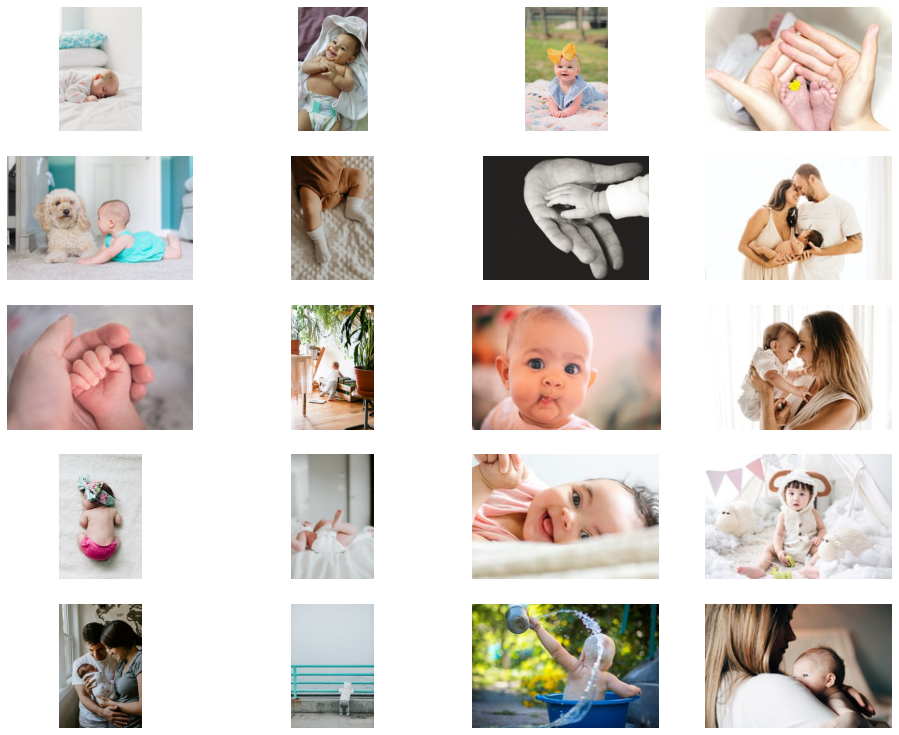

In [5]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

spider.show(page=10) 

Everything looks good. We can start to collect out dataset for the project!

## Collection
Collect images of each class.
For each query, we initialize a spider with that query, and limit the maximun number of page to 50 by default. Since each page will contain 20 images, the desired number image of each class would be 1000. However, some classes will not provide enough images and causing the imbalanced case.

For exposition, the newly collected data is only crawled from 5 pages and save into a different PATH (./datafinal)

In [6]:
for query in queries:
    spider = Scraper(query=query, num_pages=1, print_=False)
    spider.crawl()
    spider.download()

Image info is saved in './datafinal/lion.json' and total record 100.
100Images are downloaded successfully
Image info is saved in './datafinal/cat.json' and total record 100.
100Images are downloaded successfully
Image info is saved in './datafinal/dog.json' and total record 100.
100Images are downloaded successfully
Image info is saved in './datafinal/pig.json' and total record 100.
100Images are downloaded successfully
Image info is saved in './datafinal/panda.json' and total record 100.
100Images are downloaded successfully
Image info is saved in './datafinal/bull.json' and total record 100.
100Images are downloaded successfully


## Data Inspectation
After collecting all the images and the infomation in the json file in the PATH, we can inspect the data at hand. Loader functions and show functions will help.

In [7]:
# Loader
def load_img(destination =None,filename = None):
    ''' Load image from file
        @destination: string. None by default. The full path to get the image file in directory.
        @filename: string. None by default. The name of the image. It will process to be 
            the destination of the image, e.g. destination = ./data/@filename.jpg 
        return an image (Image object)
    '''
    # Process the input to get the destination of the image
    if destination is None:
        if filename is None:
            print("Destination and filename is missing.")
            return
        else:
            destination = os.path.join(PATH, f"{filename}.jpg")
    
    # Open the image from destination and return it        
    try: 
        pil_img = Image.open(destination) ###
    except:
        print("Fail to open image file: " + destination)
        pil_img = None
    finally: 
        return pil_img


def load_img_json(destination:str=None, filename:str=None):
    '''Load the image dictionary from json file
    @destination: string. The destionation of image dictionary. e.g. PATH/filename.json
    @filename: string. The filename of the image dictionary.
    return a dictionary from the file. None is returned if things go wrong
    '''
    if destination is None:
        if filename is None:
            print("Fail to load image dictionary, filename and destination are missing.")
            return dict()
        else:
            destination = os.path.join(PATH, f"{filename}.json")
    try:
        with open(destination, "r") as file:
            img_dict = json.load(file)
    except FileNotFoundError:
        print("file does not exist!")
        img_dict = None
    except:
        print("Unknown error in load_img_dict")
        img_dict = None
        
    return img_dict


def load_img_dict(destination=None, filename=None):
    return load_img_json(destination, filename)


def load_imgs_from_dict_file(destination = None, filename = None):
    ''' Load image files, which names are stored in a json file
    @destination: string. The destination of json file.
    @filename: string. The filename of json file. Usually it is the query
    return a list of Image object
    '''
    # Load in the dictionary json file: {id:url}
    img_dict = load_img_json(destination = destination, filename = filename)
    imgs = [] # for storing images
    
    # Load image from file
    for img_name in img_dict:
        img_destination = os.path.join(PATH, f"{img_name}.jpg")
        pil_img = load_img(destination = img_destination) # load image from destination
        if pil_img is None: # image could load failed.
            continue
        imgs.append((pil_img))
    return imgs

# Show
def show_img_files_in_group(destinations:list= None, filenames:list=None, shape:list=None):
    """ Show all images from the image destinations, and list into FIVE columns
    @destinations: list of image destination.
    @filename: list of image filename.
    @shape: [int, int]. Shape of the image array. None by default.
    """
    prefix = ""
    postfix = ""
    if destinations is None: # pre-process of the image destination
        if filenames is None:
            print("Destinations and filenames are missing.")
            return
        else: # update the prefix and postfix for "destinations"
            prefix = PATH + "/"
            postfix = ".jpg"
            destinations = filenames
    else: # destination is not None       
        filenames = destinations
    
    if shape is None:
        shape = [len(filenames)//4+1, 4] # [#rows, #columns]
        
    plt.figure(figsize=(16,16))
    count = 1
    for filename in filenames: 
        pil_img = load_img(destination = prefix + filename + postfix) # Load image from file
        if pil_img is None: 
            continue
        plt.subplot(shape[0],shape[1],count)
        plt.imshow(pil_img)
        plt.axis("off")
        count += 1

    plt.show()


# save label to a csv file
def save_annotations(queries = None, annotations_file = "unsplash.csv"):
    ''' Save the image annotation from .json files to a .csv file
        @queries: a list of string. e.g. ["str0, 'str1', ... ]
        return label_map = {"0": "str0", "1" : "str1",...}
    '''
    labels_map = dict()
    if queries:
        with open(annotations_file,'w',newline='') as csv_file:
            for label in range(len(queries)):
                class_dir = PATH + "/" + queries[label] + ".json"
                with open(class_dir,'r') as json_file:
                    data = json.load(json_file)
                    labels_map[str(label)] = queries[label]
                    for key in data:
                        csv_file.write(key + ".jpg, " + str(label) + ",\n")
        print("Records are saved to " + annotations_file)
    return labels_map
    

lion:


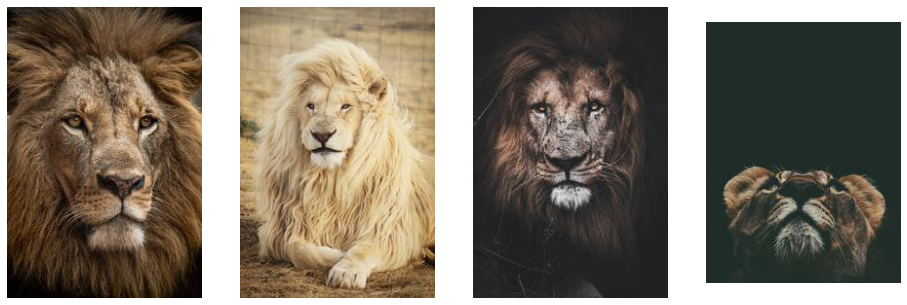

cat:


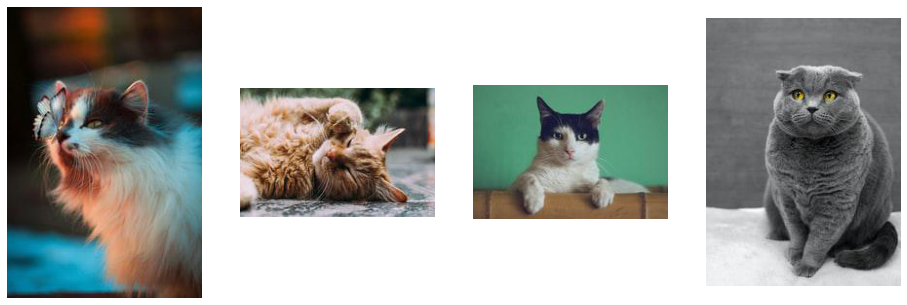

dog:


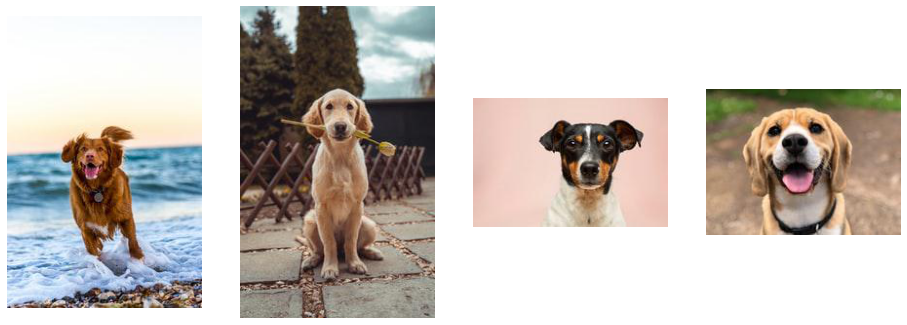

pig:


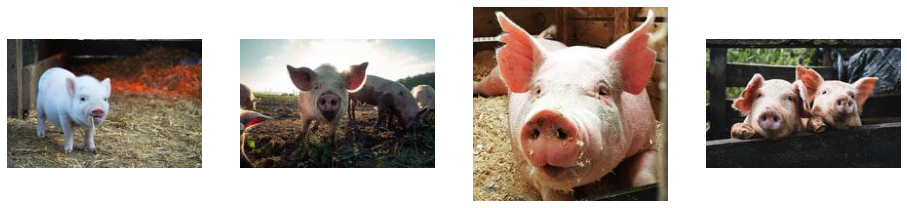

panda:


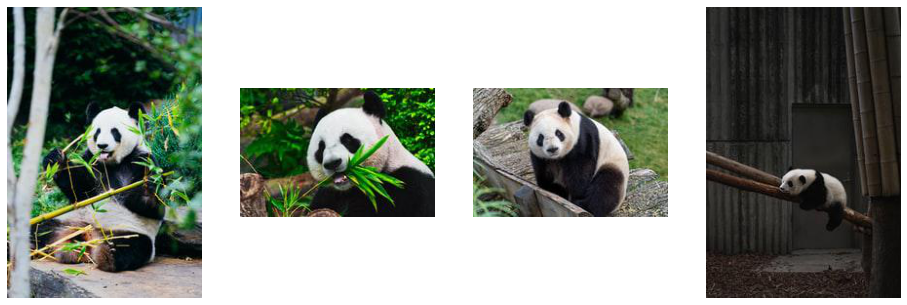

bull:


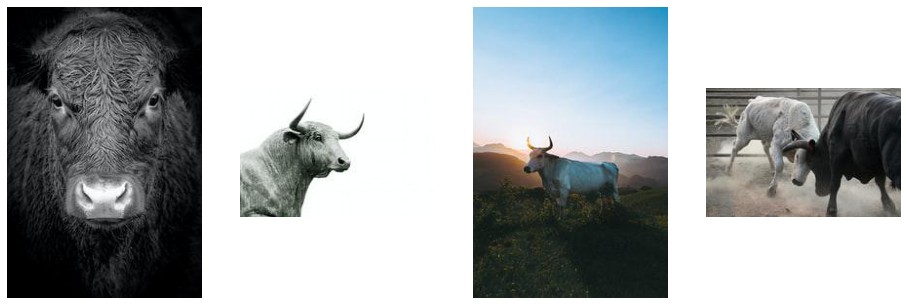

In [8]:
for query in queries:

    data = load_img_json(filename = query)
    filenames = [id for id in data.keys()]
    print(f"{query}:")
    show_img_files_in_group(destinations=None, filenames = filenames[0:4])
    
# save_annotations(queries)


What we have is what we want! We are ready to solve our bigger problem now!

# Step 3: Data exploration

**Tasks:**
1. Basic information: We will examine pictures' format, size, and resolution.
2. Discover features of pictures by Gabor filter, PCA(Principal Component Analysis) and t-SNE(t-Stochastic Neighbor Embedding)

**Conclusions:**
1. All pictures have the same width, most of pictures' height is concentrated on around 150 and 300, while the width is around 200.

2. Both Gabor features and SIFT features are not enough to classify these classes. The tsne and pca decompositions are mixed up and the clustering criteria is very low.



In [9]:
# read img
# from utils import load_imgs_from_dict_file
DEBUG = False
# if DEBUG:
#     PATH = './datafinal'
# else:
PATH = './data'
queries = ["lion", "cat", "dog", "pig", "panda","bull"]
for query in queries:
  imgs = load_imgs_from_dict_file(filename = query)

## Basic information of pictures
1. Count number of pictures in each kinds 
(lion, cat, dog, pig, panda, bull)

In [10]:
from utils import load_img_dict
for query in queries:
    data = load_img_dict(filename = query)
    print("The class of %s has %d images in files." % (query,len(data)))

The class of lion has 1000 images in files.
The class of cat has 1000 images in files.
The class of dog has 1000 images in files.
The class of pig has 940 images in files.
The class of panda has 756 images in files.
The class of bull has 1000 images in files.


2. Check size of pictures, and plot distribution of different sizes \\


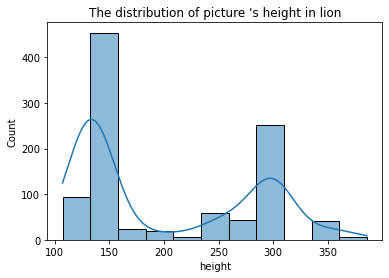

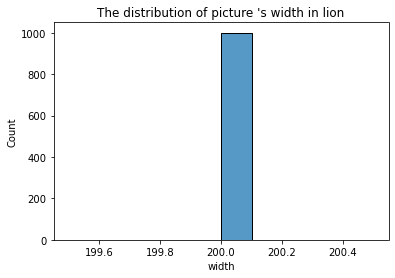

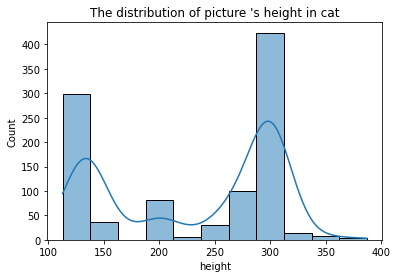

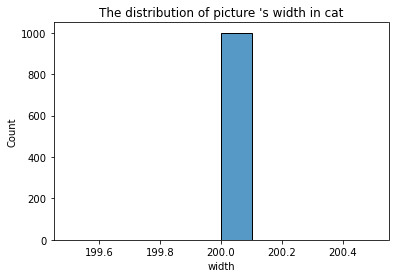

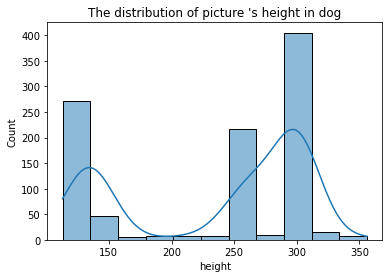

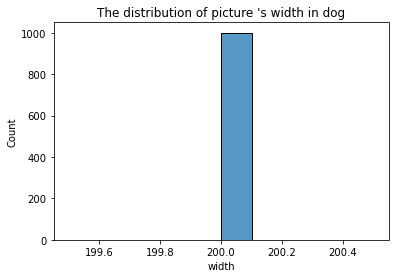

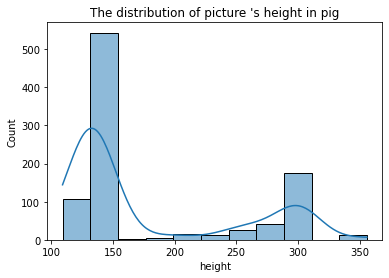

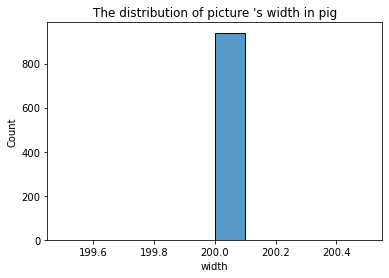

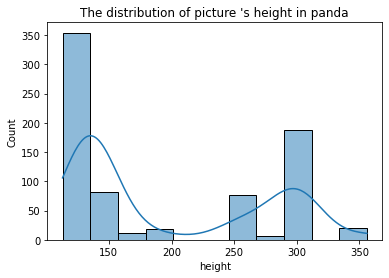

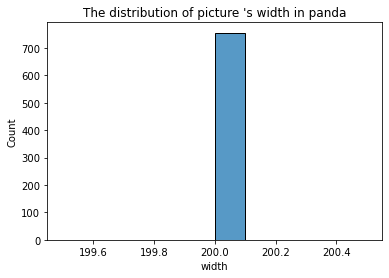

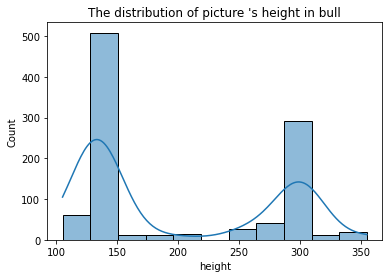

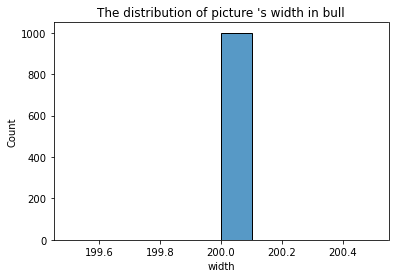

In [11]:
from utils import load_imgs_from_dict_file
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

queries = ["lion", "cat", "dog", "pig", "panda","bull"]

imgs_size = {}

for query in queries:

  plt.figure()  
  imgs_size[query] = {}

  imgs = load_imgs_from_dict_file(filename = query)
  width_list = []
  height_list = []
  for img in imgs:
    width, height = img.size
    width_list.append(width)
    height_list.append(height)
  imgs_size[query]['width'] = width_list
  imgs_size[query]['height'] = height_list
  # print(imgs_size[query]['height']
      
  df = pd.DataFrame(list(zip(width_list, height_list)),columns =['width','height'])
  # print(df)
  sns.histplot(data=df, x="height", kde=True).set_title("The distribution of picture \'s height in " + str(query))

  plt.figure()

  # sns.histplot(data=df, x="width", kde=True).set_title("The distribution of picture \'s width in " + str(query))
  sns.histplot(data=df, x="width", bins = 10).set_title("The distribution of picture \'s width in " + str(query))
  # print(set(df['width'].to_list()))

In [12]:
# Specific version of opencv
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

## Discover features

1. Gabar filter

2. SIFT filter

3. PCA & T-SNE

opencv version: 3.4.2


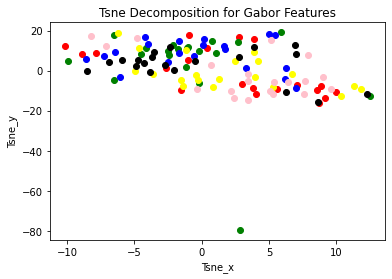

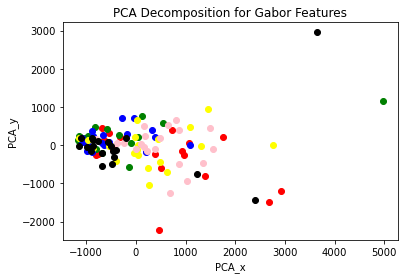

Clustering results for correlation analysis
Gabor----- NMI: 0.17137682315460412   ARI: 0.06747360288436775


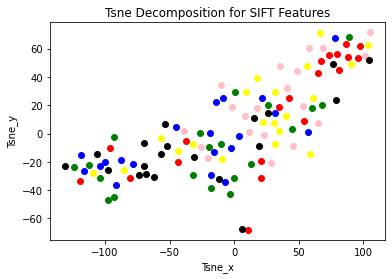

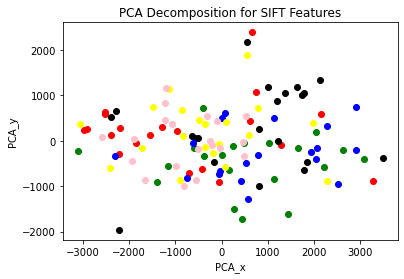

Clustering results for correlation analysis
SIFT----- NMI: 0.1634590952856782   ARI: 0.05710022667929184


In [13]:
import cv2
print("opencv version:", cv2.__version__) # make sure the version should be 3.4.2.17
import time
import numpy as np
# from google.colab.patches import cv2_imshow
# from skimage import filters
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn import decomposition
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score

''' load images (PIL) for each class '''
def get_images():
  image_dict = {}
  queries = ["lion", "cat", "dog", "pig", "panda","bull"]
  for query in queries:
    imgs = load_imgs_from_dict_file(filename = query)
    image_dict[query] = imgs
  return image_dict

''' tranform eacg image to Gabor features
    return features and labels for each image '''
def Gabor_feat(image_dict):
  # define Gabor filters
  g_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
  features = []
  labels = []

  for query in image_dict:
    imgs = image_dict[query]
    for img in imgs[:20]:
      opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
      filtered_img = cv2.filter2D(opencvImage, cv2.CV_8UC3, g_kernel)
      newimg = cv2.resize(filtered_img, (20,20), interpolation=cv2.INTER_AREA)

      features.append(newimg.flatten())
      labels.append(query)
  return features, labels

''' tranform eacg image to SIFT features
    return features and labels for each image '''
def SIFT_feat(image_dict):
  sift = cv2.xfeatures2d.SIFT_create()
  features = []
  labels = []

  for query in image_dict:
    imgs = image_dict[query]
    for img in imgs[:20]:
      opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
      gray = cv2.cvtColor(opencvImage, cv2.COLOR_BGR2GRAY)
      keypoints, descriptors = sift.detectAndCompute(opencvImage, None)
      sift_image = cv2.drawKeypoints(gray, keypoints, opencvImage)
      newimg = cv2.resize(sift_image, (20,20), interpolation=cv2.INTER_AREA)

      features.append(newimg.flatten())
      labels.append(query)
  return features, labels

''' PCA decomposition
    input: features (n*t) output: (n*2) 2 < t'''
def PCA(features):
  pca = decomposition.PCA(n_components=2)
  output = pca.fit_transform(features)
  return output

''' TSNE decomposition'''
def tsne(features):
  tsne = manifold.TSNE(
        n_components=2, init="random", random_state=0, perplexity=10)
  output = tsne.fit_transform(features)
  return output 

''' 2d visulaization 
    output: decomposed features (n*2), labels: (n*1) '''
def plot_decompose(output, labels, color_dict, title, xlabel, ylabel):
  plt.figure()
  for _i, label in enumerate(labels):
    plt.scatter(output[_i, 0], output[_i, 1], c=color_dict[label])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

''' clustering analysis based on Gabor or SIFT features '''
def clustering(features):
  kmeans = KMeans(n_clusters=6, random_state=0).fit(features)
  kmeans_labels = kmeans.labels_
  return kmeans_labels

image_dict = get_images()

# Gabor
features, labels = Gabor_feat(image_dict)
tsne_output = tsne(features)
pca_output = PCA(features)

color_dict = {"lion": "red", "cat": "green", "dog": "blue", "pig": "yellow", "panda": "pink", "bull": "black"}
title, xlabel, ylabel = "Tsne Decomposition for Gabor Features", "Tsne_x", "Tsne_y"
plot_decompose(tsne_output, labels, color_dict, title, xlabel, ylabel)
title, xlabel, ylabel = "PCA Decomposition for Gabor Features", "PCA_x", "PCA_y"
plot_decompose(pca_output, labels, color_dict, title, xlabel, ylabel)

color_dict = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "pink", 5: "black"}
kmeans_labels = clustering(features)
# plot_decompose(tsne_output, kmeans_labels, color_dict)
# plot_decompose(pca_output, kmeans_labels, color_dict)

gt_dict = {"lion": 0, "cat": 1, "dog": 2, "pig": 3, "panda": 4, "bull": 5}
gt_labels = []
for label in labels:
  gt_labels.append(gt_dict[label])

# evaluation for clustering results using Gabor feat
NMI = normalized_mutual_info_score(kmeans_labels, gt_labels)
ARI = adjusted_rand_score(kmeans_labels, gt_labels)
print("Clustering results for correlation analysis")
print("Gabor-----", "NMI:", NMI, "  ARI:", ARI)

# SIFT
features, labels = SIFT_feat(image_dict)
tsne_output = tsne(features)
pca_output = PCA(features)

color_dict = {"lion": "red", "cat": "green", "dog": "blue", "pig": "yellow", "panda": "pink", "bull": "black"}
title, xlabel, ylabel = "Tsne Decomposition for SIFT Features", "Tsne_x", "Tsne_y"
plot_decompose(tsne_output, labels, color_dict, title, xlabel, ylabel)
title, xlabel, ylabel = "PCA Decomposition for SIFT Features", "PCA_x", "PCA_y"
plot_decompose(pca_output, labels, color_dict, title, xlabel, ylabel) 

color_dict = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "pink", 5: "black"}
kmeans_labels = clustering(features)
# plot_decompose(tsne_output, kmeans_labels, color_dict)
# plot_decompose(pca_output, kmeans_labels, color_dict)

gt_dict = {"lion": 0, "cat": 1, "dog": 2, "pig": 3, "panda": 4, "bull": 5}
gt_labels = []
for label in labels:
  gt_labels.append(gt_dict[label])

# evaluation for clustering results using SIFT feat
NMI = normalized_mutual_info_score(kmeans_labels, gt_labels)
ARI = adjusted_rand_score(kmeans_labels, gt_labels)
print("Clustering results for correlation analysis")
print("SIFT-----", "NMI:", NMI, "  ARI:", ARI)

# Step 4: Pre-processing

**Tasks:**

We normalize  the  pixels  of  various  photos into the range 0 to 1.   We  tune  the  choice  of data augmentations,  e.g.,  resize,  flip,  and affine transformations.  Besides, we manually filter out ”hard” samples, such as photos of extreme small/large outlier objects.  Finally,we can get ~1,000 pictures in each kind and split these pictures into train,  validation,  and test dataset.  These pre-processing procedures can ensure that the data is balanced in different classifications and avoid overfitting.


In [62]:
# Import packages
import os
import random
import copy
import json
from PIL import Image
from typing import List, Optional, Callable, Tuple
import time

import numpy as np
import torch
from torch import nn, optim
from torch import Tensor
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms, utils
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from sklearn import manifold


## Dataset

In [63]:
class MyDataset(data.Dataset):
    shuffled_indices = None

    def __init__(self, root: str = './data/',
                 classes: List[str] = ['bull', 'cat', 'dog', 'lion', 'panda', 'pig'],
                 split: str = 'train', transform: Optional[Callable] = None):
        self.root = root
        self.classes = copy.deepcopy(classes)
        self.num_classes = len(self.classes)

        self.class_label_mapping = {}
        for label_idx, class_ in enumerate(self.classes):
            self.class_label_mapping[class_] = label_idx

        self.split = split
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.CenterCrop(IMG_SIZE),
                transforms.ToTensor()
            ])
        self.transform = transform

        # Main attributes
        self.imgs, self.labels = [], []
        self.img_names = []

        # Read from json files
        for class_ in self.classes:
            json_pth = os.path.join(root, f"{class_}.json")
            with open(json_pth) as json_file:
                json_data = json.load(json_file)

            self.img_names.extend(list(json_data.keys()))
            num_imgs_of_class = len(json_data)
            self.labels.extend([self.class_label_mapping[class_]
                                for _ in range(num_imgs_of_class)])
        
        # '''
        # Shuffle data and labels
        # Split slicing
        train_ratio, val_ratio = 0.8, 0.1
        total_num = len(self.img_names)
        train_num, val_num = int(total_num * train_ratio), int(total_num * val_ratio)
        test_num = total_num - train_num - val_num

        # :shuffled_indices: is fixed at the beginning
        if MyDataset.shuffled_indices is None:
            MyDataset.shuffled_indices = np.random.permutation(len(self.img_names))
        if self.split == 'train':
            split_indices = MyDataset.shuffled_indices[: train_num]
        elif self.split == 'val':
            split_indices = MyDataset.shuffled_indices[train_num: train_num + val_num]
        else:  # test
            split_indices = MyDataset.shuffled_indices[-test_num:]

        print(f"> Loading images for {self.split}")

        self.img_names = [self.img_names[idx] for idx in split_indices]
        self.imgs = [Image.open(os.path.join(self.root, f'{img_name}.jpg'))
                     for img_name in self.img_names]
        self.labels = [self.labels[idx] for idx in split_indices]

        # # Store data in .npy
        # np.save(os.path.join(self.root, f'{self.split}_data.npy'),
        #         {'imgs': np.array(self.imgs, dtype=object),
        #          'labels': np.array(self.labels)})
        # '''

        # print(f"> Loading images for {self.split}")
        # data = np.load(os.path.join(self.root, f'{self.split}_data.npy'), allow_pickle=True).item()
        # self.imgs = data['imgs'].tolist()
        # self.labels = data['labels'].tolist()

    def __getitem__(self, index) -> Tuple[Tensor, int]:
        img = self.imgs[index]
        if self.transform:
            img = self.transform(img)  # `transform` should include `transforms.ToTensor()`
        label = self.labels[index]

        return img, label

    def __len__(self):
        return len(self.imgs)


In [64]:
# Test the dataset
DATA_DIR = './data/'

IMG_SIZE = 48

transform = transforms.Compose([
	transforms.Resize(IMG_SIZE),
	transforms.CenterCrop(IMG_SIZE),
	transforms.ToTensor()
])
dataset = MyDataset(root=DATA_DIR, split='train', transform=transform)


> Loading images for train


len(dataset) (train) 4556


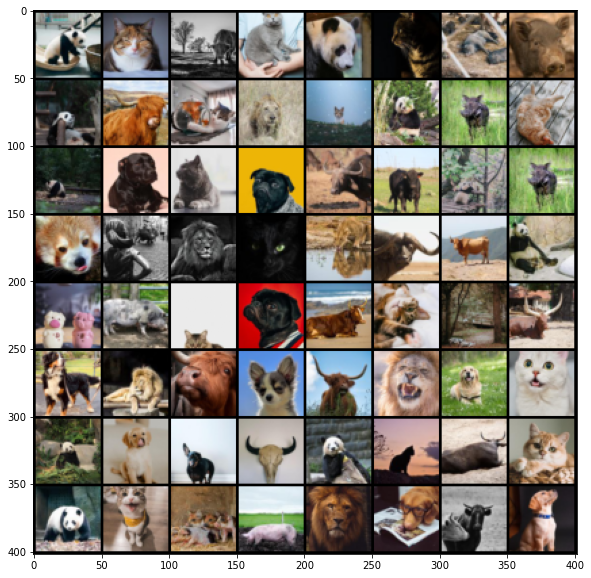

In [17]:
# Glance of images
num_samples = 64

print("len(dataset) (train)", len(dataset))

def viz_batch_of_dataset(dataset):
    sample_imgs = [dataset[idx][0] for idx in range(num_samples)]
    sample_imgs = torch.cat(sample_imgs).reshape(num_samples, *sample_imgs[0].shape)  # shape: (B, C, H, W)
    img_grid = utils.make_grid(sample_imgs)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))

viz_batch_of_dataset(dataset)


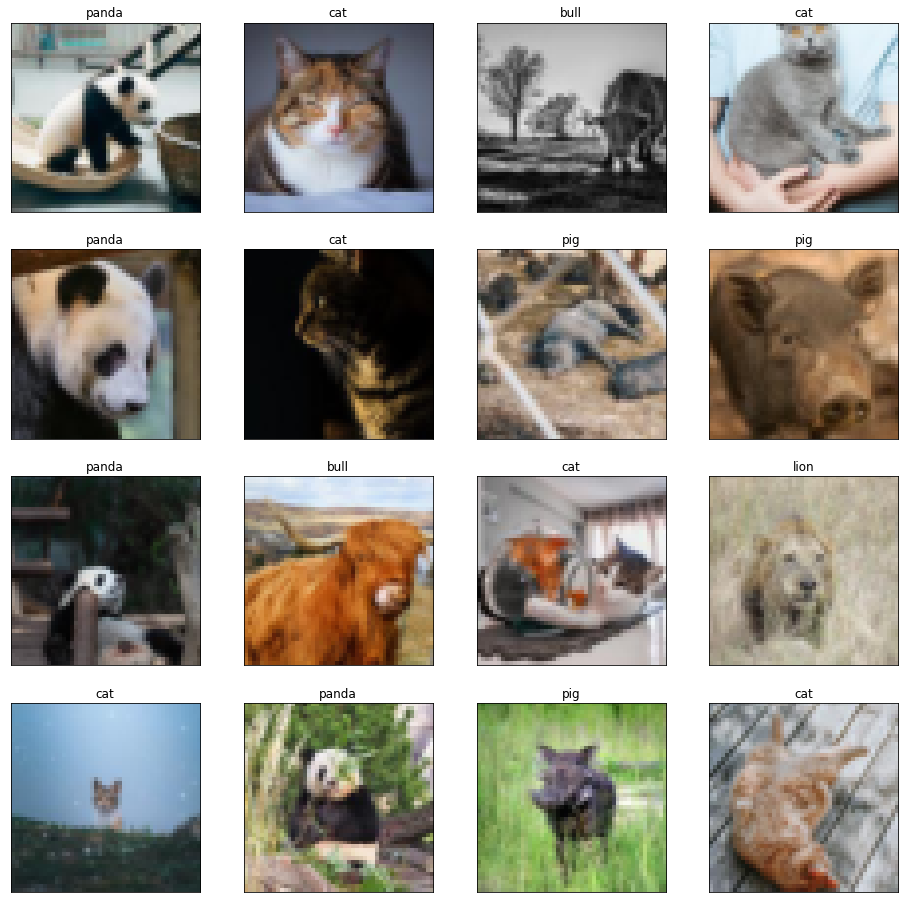

In [18]:
# Show images together with labels
nrow, ncol = 4, 4
total_num = nrow * ncol
_, axes = plt.subplots(nrow, ncol, figsize=(16, 16))

for idx in range(total_num):
    h, w = idx // 4, idx % 4
    img, label = dataset[idx]
    axes[h][w].imshow(img.permute(1, 2, 0))
    axes[h][w].set_xticks([])
    axes[h][w].set_yticks([])
    axes[h][w].set_title(dataset.classes[label])

plt.show()


## Data Augmentation

We first resize the shorter edge of the image into `IMG_SIZE`. As for data
augmentation, we consider conventional random resized crop, horizontal flip, and
color jitter. This is based on the observation in data exploration - resolutions of images relatively evenly cluster at 150 x 200, 300 x 200. When resized to 48, images will result in around 3x to 4x resolution strides. The model will learn to deal with these resolutions. The aim of data augmentation is to enrich the diversity of the dataset as well as act
as a regularization [[1]](https://arxiv.org/abs/2002.08973). In the evaluation,
we do not apply data augmentation except center crop. Besides, we randomly split the dataset according to the ratio, train: val: test = 8: 1: 1.


In [19]:
# Datasets and dataloaders
DATA_DIR = './data/'
BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1)),
    # transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.1, contrast=.1, saturation=.1),
    transforms.ToTensor()
])
print("> Data augmentation", train_transform)
train_dataset = MyDataset(root=DATA_DIR, split='train', transform=train_transform)
val_dataset = MyDataset(root=DATA_DIR, split='val')  # default test transforms
test_dataset = MyDataset(root=DATA_DIR, split='test')
print(f"> Train num: {len(train_dataset)}, Val num: {len(val_dataset)},"
      f" Test num {len(test_dataset)}")
    
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                   shuffle=True, pin_memory=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


> Data augmentation Compose(
    Resize(size=48, interpolation=bilinear, max_size=None, antialias=None)
    RandomResizedCrop(size=(48, 48), scale=(0.8, 1), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=None)
    ToTensor()
)
> Loading images for train
> Loading images for val
> Loading images for test
> Train num: 4556, Val num: 569, Test num 571


# Step 5: Data analysis with deep learning

**Tasks:**

1. **Baseline** of MLP, CNN, RNN and ANN in animal recoginition.

2. **Improvement** based on MLP, CNN, RNN and ANN in animal recoginition.

**Conclusions:**

| Model | #Parameters | Accuracy |
| - | :-: | :-: |
| MLP Baseline | 41M | 44.13 |
| CNN Baseline | 89M | 89.84 |
| RNN Baseline | 104M | 62.70 |
| ANN Baseline | 158M | 80.04 |
| MLP Improvement | 903M | 91.59 |
| CNN Improvement | 175M | 96.85 |
| RNN Improvement | 1004M | 93.70 |
| ANN Improvement | 1499M | 91.59 |


## Evaluation


We use conventional (top-1) accuracy as our metric in the classification task.


In [20]:
# Evaluation
def compute_accuracy(logits: Tensor, targets: Tensor) -> Tensor:
    """ Top-1 accuracy."""
    return torch.mean(logits.max(1)[1].eq(targets).float())


def validate(model: nn.Module, dataloader: data.DataLoader) -> Tuple[float, float]:
    loss, acc = 0., 0.

    model.eval()

    for imgs, labels in dataloader:
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        with torch.no_grad():
            outputs = model(imgs)
        curr_batch_size = imgs.shape[0]
        loss += criterion(outputs, labels).item() * curr_batch_size  # first accumulate 
                                                                     # :criterion: is a global var
        acc += compute_accuracy(outputs, labels).item() * curr_batch_size

    # Mean
    total_num = len(dataloader.dataset)
    loss /= total_num
    acc /= total_num

    return loss, acc


# Test
def test(model: nn.Module, ckpt_pth: Optional[str] = None) -> None:
    """ Test performance. Print the results in the process."""
    if ckpt_pth is not None:
        model.load_state_dict(torch.load(ckpt_pth, map_location=DEVICE)['model'])
    
    test_loss, test_acc = validate(model, test_dataloader)
    
    print(f"> Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}")


## Training

### Implementation

We use [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html?highlight=adamw#torch.optim.AdamW)
optimizer with weight decay (similar to L2 regularization) for all experiments to alleviate overfitting.

In [21]:
train_losses, train_accs, val_losses, val_accs, val_iters, lrs = [], [], [], [], [], []


# Metric helpers
class AvgMeter:
    def __init__(self) -> None:
        self.num, self.sum = 0, 0.
    
    def update(self, mean: float, num: int) -> None:
        self.num += num
        self.sum += num * mean

    @property
    def mean(self) -> float:
        return self.sum / self.num if self.num else 0.


# Main course
def train(model: nn.Module) -> None:
    """ Set the :optimizer:, :lr_scheduler:, and :criterion: ahead."""
    global step, train_losses, train_accs, val_losses, val_accs, val_iters, lrs

    train_losses, train_accs = [], []
    val_losses, val_accs, val_iters = [], [], []
    lrs = []
    
    start_time = time.time()

    step = start_step
    
    for epoch in range(start_epoch, EPOCHS):
        loss_meter, acc_meter = AvgMeter(), AvgMeter()  # accumulate in each epoch
    
        for batch_idx, (imgs, labels) in enumerate(train_dataloader):
            step += 1
     
            model.train()
            
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lr_scheduler.step()
            lrs.append(optimizer.param_groups[0]['lr'])
    
            # Metrics
            with torch.no_grad():
                acc = compute_accuracy(outputs, labels)
    
            # For plotting the training process
            curr_batch_size = imgs.shape[0]  # consider the last batch which may be < :BATCH_SIZE:
            loss_meter.update(loss.item(), curr_batch_size)
            acc_meter.update(acc.item(), curr_batch_size)
            train_losses.append(loss_meter.mean)
            train_accs.append(acc_meter.mean)
    
            is_last = (step == ITERS - 1
                       or epoch == EPOCHS - 1 and batch_idx == len(train_dataloader) - 1)
            if (step + 1) % PRINT_FREQ == 0 or step == 0 or is_last:
                # Validate
                val_loss, val_acc = validate(model, val_dataloader)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_iters.append(step)
    
                # Metrics of the current iteration
                print(f"Epoch-Iter [{epoch}-{step}]"
                      f"\tTrain loss: {loss.item():.6f} Train acc: {acc.item():.5f};"
                      f" Val loss: {val_loss:.6f} Val acc: {val_acc:.5f}"
                      f" LR: {lrs[-1]:.6f} |"
                      f" Time: {(time.time() - start_time) / (step - start_step):.4f}")
        
            if (step + 1) % SAVE_FREQ == 0 or step == 0 or is_last:
                state_dict = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    # 'lr_scheduler': lr_scheduler.__dict__,
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'step': step,
                }
                torch.save(state_dict, os.path.join(MODEL_DIR, f'{step}.tar'))
    
            if step == ITERS - 1:
                break
        
        if step == ITERS - 1:
            break


In [22]:
# Visualize the training process
def viz_training_curves():
    if step == start_step or len(train_losses) == 0:
        return
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(start_step, step), train_losses, label='train')
    plt.plot(val_iters, val_losses, label='val')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(start_step, step), train_accs, label='train')
    plt.plot(val_iters, val_accs, label='val')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()


def viz_lrs():
    """ Viz LR scheduler."""
    plt.figure(figsize=(5, 4))
    plt.plot(np.arange(start_step, step), lrs, label='LR')
    plt.xlabel('Iteration')
    plt.ylabel('LR')
    plt.grid()
    plt.legend()


### [Cosine Annealing LR Scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html?highlight=cosine%20annealing#torch.optim.lr_scheduler.CosineAnnealingLR)

In this work, we keep using a conventional cosine annealing LR scheduler. It
first warms up with linearly increasing LRs, and then LRs anneal with cosine.
See the plot of LRs later.

$\eta_t=\eta_{min}+\frac12(\eta_{max}-\eta_{min})\left(1+\cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right)$


In [23]:
# LR scheduler
# See the plot of LRs later
import math


def get_cosine_schedule_with_warmup(
    optimizer: optim.Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)


### Common Hyperparam Configurations

Here, we include some details of training epochs, etc., commonly used in this work.

In [24]:
# Other shared configurations
DEVICE = 'cuda:0'  # use GPU

# Training
EPOCHS = 40  # also related to BATCH_SIZE
ITERS = 3000  # we also provide iterations, ~ 1000 * NUM_CLASSES / BATCH_SIZE * EPOCHS
WARMUPS = int(0.01 * ITERS)

# Evaluation
PRINT_FREQ = 100
SAVE_FREQ = 100


## Model 1: MLP

### MLP Baseline

We first implement a single linear layer $\mathbf{y}=\mathbf{W}^T\mathbf{x}+\mathbf{b}$, where $\mathbf{x}$ is the input data and $\mathbf{y}$ is output logits.


In [25]:
class MLP_baseline(nn.Module):
    """ 1-layer MLP baseline."""
    def __init__(self, input_dim: int, num_classes: int) -> None:
        super(MLP_baseline, self).__init__()

        self.layer1 = nn.Linear(input_dim, num_classes)
        
    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(1)
        x = self.layer1(x)

        return x


In [26]:
# MLP configurations
INPUT_DIM = 3 * IMG_SIZE ** 2

model = MLP_baseline(INPUT_DIM, dataset.num_classes).cuda()
print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 41478
MLP_baseline(
  (layer1): Linear(in_features=6912, out_features=6, bias=True)
)


We train to optimize the Cross Entropy $\mathcal{L}=-\sum_i y_i\log Softmax(\hat{y}_i)$, where $\hat{y}_i$ is predicted logits and $y_i$ is the one-hot label. The training (and valiation) logs and curves are displayed.

Epoch-Iter [0-0]	Train loss: 1.854450 Train acc: 0.12500; Val loss: 1.806246 Val acc: 0.18453 LR: 0.000033 | Time: 0.5255
Epoch-Iter [1-99]	Train loss: 1.671211 Train acc: 0.31250; Val loss: 1.828985 Val acc: 0.29701 LR: 0.000999 | Time: 0.0471
Epoch-Iter [2-199]	Train loss: 1.548529 Train acc: 0.43750; Val loss: 1.627273 Val acc: 0.39543 LR: 0.000992 | Time: 0.0429
Epoch-Iter [4-299]	Train loss: 1.507941 Train acc: 0.40625; Val loss: 1.530417 Val acc: 0.39895 LR: 0.000980 | Time: 0.0413
Epoch-Iter [5-399]	Train loss: 1.572420 Train acc: 0.35938; Val loss: 1.544845 Val acc: 0.41301 LR: 0.000962 | Time: 0.0406
Epoch-Iter [6-499]	Train loss: 1.328097 Train acc: 0.48438; Val loss: 1.567984 Val acc: 0.37434 LR: 0.000939 | Time: 0.0404
Epoch-Iter [8-599]	Train loss: 1.671395 Train acc: 0.40625; Val loss: 1.540123 Val acc: 0.37610 LR: 0.000912 | Time: 0.0400
Epoch-Iter [9-699]	Train loss: 1.568064 Train acc: 0.39062; Val loss: 1.655164 Val acc: 0.36204 LR: 0.000880 | Time: 0.0398
Epoch-Iter 

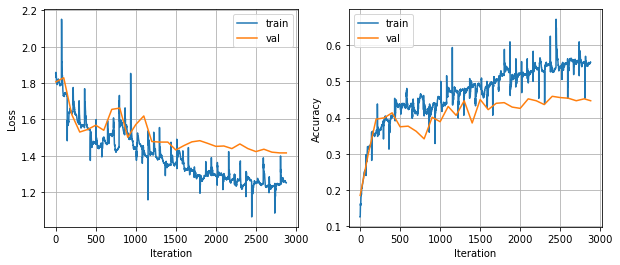

In [27]:
LR = 1e-3
WEIGHT_DECAY = 5e-5

MODEL_DIR = './ckpts/mlp_baseline/'

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()  #.cuda()

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # consider weight decay
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

# Dir to save the model checkpoint
if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)

start_epoch, start_step = 0, -1
train(model)

viz_training_curves()


The plot of LRs is shown as below. It does not vary across experiments.

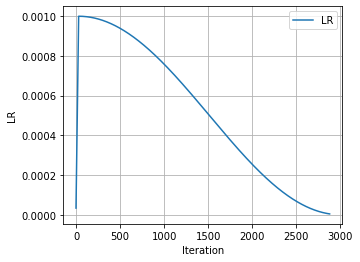

In [28]:
viz_lrs()


Here is the performance of the MLP baseline on the test dataset.

In [29]:
test(model, './ckpts/mlp_baseline/2879.tar')


> Test loss: 1.41917, Test acc: 0.44133


### Our Improved MLP

Single linear layer can only do simple template matching and fails to capture complicated patterns, e.g.,  translation-invariant ones. So we improve the representative power of the baseline by stacking more layers and nonlinearities $\sigma=ReLU$. We show the performance of a (3-layer) MLP baseline on the task. For MLP, we also use 1D [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm1d#torch.nn.BatchNorm1d), $$\hat{x}_i=\frac{x_i-mean(x_i)}{std(x_i)},$$ to stablize training.


In [30]:
class MLP(nn.Module):
    """ 3-layer MLP baseline."""
    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int) -> None:
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu2 = nn.ReLU(inplace=True)
        self.layer3 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(1)
        x = self.relu1(self.bn1(self.layer1(x)))
        x = self.relu2(self.bn2(self.layer2(x)))
        x = self.layer3(x)

        return x


In [31]:
# MLP configurations
INPUT_DIM = 3 * IMG_SIZE ** 2
HIDDEN_SIZE = 128

model = MLP(INPUT_DIM, HIDDEN_SIZE, dataset.num_classes).cuda()
print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 902662
MLP(
  (layer1): Linear(in_features=6912, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (layer3): Linear(in_features=128, out_features=6, bias=True)
)


Epoch-Iter [0-0]	Train loss: 1.826837 Train acc: 0.18750; Val loss: 1.795257 Val acc: 0.16344 LR: 0.000033 | Time: 0.2035
Epoch-Iter [1-99]	Train loss: 1.367491 Train acc: 0.45312; Val loss: 1.475927 Val acc: 0.40246 LR: 0.000999 | Time: 0.0429
Epoch-Iter [2-199]	Train loss: 0.975830 Train acc: 0.65625; Val loss: 1.542184 Val acc: 0.40598 LR: 0.000992 | Time: 0.0410
Epoch-Iter [4-299]	Train loss: 1.234286 Train acc: 0.43750; Val loss: 1.443478 Val acc: 0.43761 LR: 0.000980 | Time: 0.0407
Epoch-Iter [5-399]	Train loss: 0.883835 Train acc: 0.67188; Val loss: 1.298283 Val acc: 0.48155 LR: 0.000962 | Time: 0.0405
Epoch-Iter [6-499]	Train loss: 0.730708 Train acc: 0.70312; Val loss: 1.416632 Val acc: 0.52197 LR: 0.000939 | Time: 0.0407
Epoch-Iter [8-599]	Train loss: 0.588720 Train acc: 0.76562; Val loss: 1.404701 Val acc: 0.50615 LR: 0.000912 | Time: 0.0407
Epoch-Iter [9-699]	Train loss: 0.591282 Train acc: 0.81250; Val loss: 0.956308 Val acc: 0.61863 LR: 0.000880 | Time: 0.0407
Epoch-Iter 

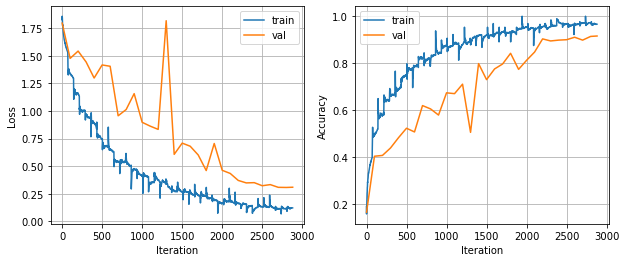

In [32]:
# Hyperparams for training MLP
LR = 1e-3
WEIGHT_DECAY = 5e-5

MODEL_DIR = './ckpts/mlp/'

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # consider weight decay
# lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-6)
# lr_scheduler = NoamOpt(1, LR * WARMUPS ** 0.5, WARMUPS, optimizer)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

# Dir to save the model checkpoint
if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1
train(model)

viz_training_curves()

test(model, './ckpts/mlp/2879.tar')


## Model 2: CNN

### CNN Baseline

Convolution is a design with local receptive fields which integrates some inductive biases helpful to capture visual patterns. It adopts shared parameters, which makes it efficient and less prone to overfitting than fully connected layers. We first implement a CNN baseline with several stacked convolution layers followed by a nonlinear classifier. The model may capture local low-level features in shallow layers and cover larger part of the image gradually moving to deeper layers.

In [33]:
class CNN_baseline(nn.Module):

    def __init__(self, planes=[16,32, 32], num_classes=6):

        super(CNN_baseline, self).__init__()
 
        self.conv1 = nn.Conv2d(3,   planes[0],  kernel_size=3, padding=1 )
        self.conv2 = nn.Conv2d(planes[0], planes[1],  kernel_size=3, padding=1 )
        self.conv3 = nn.Conv2d(planes[1], planes[2],  kernel_size=3, padding=1 )
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(int(IMG_SIZE**2/4**3*planes[-1]), 64)
        self.linear2 = nn.Linear(64, num_classes)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # linear layers:
        x = x.flatten(1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x) 
        
        return x
        

#Total params 88518
CNN_baseline(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1152, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=6, bias=True)
)
Epoch-Iter [0-0]	Train loss: 1.778443 Train acc: 0.21875; Val loss: 1.787981 Val acc: 0.19684 LR: 0.000167 | Time: 0.1919


/home/nus/miniconda3/envs/deeplearn_course/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch-Iter [1-99]	Train loss: 1.600118 Train acc: 0.39062; Val loss: 1.530717 Val acc: 0.40773 LR: 0.004993 | Time: 0.0423
Epoch-Iter [2-199]	Train loss: 1.313568 Train acc: 0.51562; Val loss: 1.242176 Val acc: 0.52021 LR: 0.004960 | Time: 0.0415
Epoch-Iter [4-299]	Train loss: 1.128884 Train acc: 0.67188; Val loss: 1.119738 Val acc: 0.56591 LR: 0.004899 | Time: 0.0409
Epoch-Iter [5-399]	Train loss: 0.643206 Train acc: 0.75000; Val loss: 0.964313 Val acc: 0.65729 LR: 0.004811 | Time: 0.0409
Epoch-Iter [6-499]	Train loss: 0.784098 Train acc: 0.75000; Val loss: 0.854791 Val acc: 0.67663 LR: 0.004697 | Time: 0.0415
Epoch-Iter [8-599]	Train loss: 0.571060 Train acc: 0.82812; Val loss: 0.706932 Val acc: 0.75747 LR: 0.004559 | Time: 0.0414
Epoch-Iter [9-699]	Train loss: 0.379012 Train acc: 0.85938; Val loss: 0.696528 Val acc: 0.75044 LR: 0.004398 | Time: 0.0414
Epoch-Iter [11-799]	Train loss: 0.458630 Train acc: 0.82812; Val loss: 0.670909 Val acc: 0.74517 LR: 0.004216 | Time: 0.0412
Epoch-It

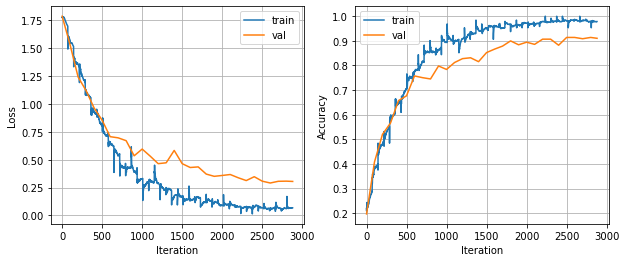

In [34]:
# Hyperparams for training CNN
LR = 5e-3
# LR = 1e-3
WEIGHT_DECAY = 5e-5

MODEL_DIR = './ckpts/cnn_baseline/'

model = CNN_baseline().cuda()
print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # consider weight decay
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1
train(model)

viz_training_curves()

test(model, './ckpts/cnn_baseline/2879.tar')


### Our Improved CNN

To achieve better performance, we need a more elaborated NN structure. We further improve on the baseline by constructing and training a 15-layer ResNet-like CNN. Many designs of ResNet like residual shortcuts, regular cell blocks, have shown a big hit in computer vision tasks. Residual shortcuts, $\hat{x}=x+f(x)$, where $f$ is trained to learn the residual, ease the backpropagation of gradients and ensemble the model, making us able to train deeper CNNs. Regular cell blocks are also verified as efficient by NN architecture search. A ResNet structure is like,

![ResNet](figs/resnet.png)[[1]](https://arxiv.org/abs/1512.03385)


In [35]:
class BasicBlock(nn.Module):
    """ Analogous to the implementation of PyTorch."""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CNN(nn.Module):
    """ 20 layers."""
    def __init__(self, block=BasicBlock, num_blocks=[3, 3, 3], num_classes=6):
        super(CNN, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


#Total params 174998
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, mom

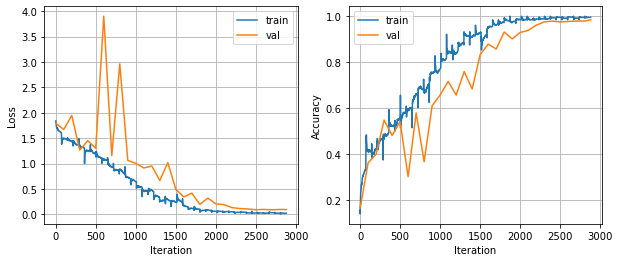

In [36]:
# Hyperparams for training CNN
LR = 5e-3
WEIGHT_DECAY = 5e-5

MODEL_DIR = './ckpts/cnn/'

model = CNN(num_blocks=[2, 2, 2]).cuda()
print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # consider weight decay
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1
train(model)

viz_training_curves()

test(model, './ckpts/cnn/2879.tar')


## Model 3: RNN
 

### RNN Baseline

RNN is another popular kind of classical DL models with different unique inductive biases. We can treat an image as a sequence of non-overlapped patches, e.g., of $8\times8$ size, to apply RNNs. Basically, patches are analogous to words or temporal features in sequence modeling. Just like sentiment analysis, the model finally predicts a class based on global hidden representations extracted from local information using a temporal mean pooling. This idea was actually explored at the early stage of computer vision and now becomes popular again when met with Transformer. We first implement a RNN baseline to do the task. A RNN can be written as,
$\mathbf{h}_t=\sigma(R\mathbf{h}_{t-1}+V\mathbf{x}_t)$, where $R,V$ are model parameters, and $\mathbf{h}_t$ is hidden states.


In [37]:
# RNN
# !pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class RNN_baseline(nn.Module):
    """ Analogous to ViT."""
    def __init__(self, *, image_size, patch_size, num_classes, dim, hidden_size, num_layers=1, channels = 3):
        super(RNN_baseline, self).__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.rnn = nn.RNN(dim, hidden_size, num_layers, batch_first=True)

        self.to_latent = nn.AdaptiveAvgPool1d(1)  # temporal average pooling

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, unused_n, _ = x.shape

        # Refer to PyTorch docs
        h_init = torch.zeros(self.rnn.num_layers, b, self.rnn.hidden_size).cuda()

        # if self.training:
        #     h_init.requires_grad_()

        x, unused_h_final = self.rnn(x, h_init)

        x = x.transpose(2, 1)
        x = self.to_latent(x).view(b, -1)

        return self.mlp_head(x)

# Test RNN model
NUM_CLASSES = 6
SEQ_LEN = 36
DIM = 64
HIDDEN_SIZE = 128
# NUM_LAYERS = 1
NUM_LAYERS = 3

model = RNN_baseline(
    image_size=IMG_SIZE,
    patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
    num_classes=NUM_CLASSES,
    dim=DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
).cuda()

print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 104262
RNN_baseline(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=192, out_features=64, bias=True)
  )
  (rnn): RNN(64, 128, num_layers=3, batch_first=True)
  (to_latent): AdaptiveAvgPool1d(output_size=1)
  (mlp_head): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=6, bias=True)
  )
)


Epoch-Iter [0-0]	Train loss: 1.965620 Train acc: 0.15625; Val loss: 1.977605 Val acc: 0.16872 LR: 0.000033 | Time: 0.1888
Epoch-Iter [1-99]	Train loss: 1.649936 Train acc: 0.32812; Val loss: 1.728768 Val acc: 0.22320 LR: 0.000999 | Time: 0.0461
Epoch-Iter [2-199]	Train loss: 1.748302 Train acc: 0.25000; Val loss: 1.693952 Val acc: 0.27592 LR: 0.000992 | Time: 0.0440
Epoch-Iter [4-299]	Train loss: 1.635715 Train acc: 0.29688; Val loss: 1.629160 Val acc: 0.30580 LR: 0.000980 | Time: 0.0437
Epoch-Iter [5-399]	Train loss: 1.663212 Train acc: 0.26562; Val loss: 1.632850 Val acc: 0.32337 LR: 0.000962 | Time: 0.0432
Epoch-Iter [6-499]	Train loss: 1.651489 Train acc: 0.35938; Val loss: 1.671954 Val acc: 0.30756 LR: 0.000939 | Time: 0.0431
Epoch-Iter [8-599]	Train loss: 1.591028 Train acc: 0.32812; Val loss: 1.539770 Val acc: 0.41828 LR: 0.000912 | Time: 0.0433
Epoch-Iter [9-699]	Train loss: 1.402040 Train acc: 0.50000; Val loss: 1.497219 Val acc: 0.39192 LR: 0.000880 | Time: 0.0433
Epoch-Iter 

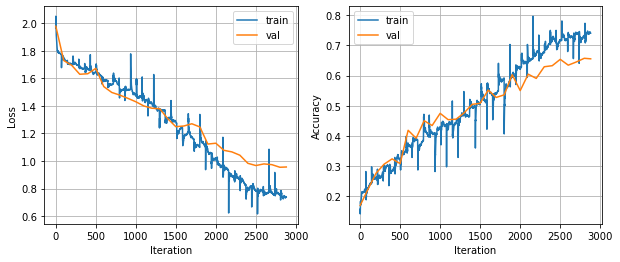

In [38]:
# Training RNN_baseline
EPOCHS = 40
ITERS = 3000

LR = 1e-3
WEIGHT_DECAY = 1e-4

MODEL_DIR = './ckpts/rnn_baseline/'

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
	os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1  # remember first to set
train(model)

# Evaluate RNN
viz_training_curves()

test(model, './ckpts/rnn_baseline/2879.tar')


### Our Improved RNN

Vanilla RNN is incapable of modeling long sequences. In our task, the length of the patch sequence is at least 36 since smaller patches seem of fewer meanings. By contrast, LSTM does a better job. It is designed to give a chance to memorize and forget short-term and long-term information and found more efficient for not suffering from vanishing gradient problems. We use a three-layer bidirectional LSTM as backbone. Thus, it can use more comprehensive contexts from neighbors in two directions instead of only one. Here is the formula and an illustration of BiLSTM in NLP.

![LSTM Equation](figs/lstm_eq.png)

![BiLSTM](figs/bilstm.png)[[1]](https://paperswithcode.com/method/bilstm)


In [39]:
# RNN
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class RNN(nn.Module):
    """ Analogous to ViT."""
    def __init__(self, *, image_size, patch_size, num_classes, dim, hidden_size, num_layers, channels = 3, dropout = 0., emb_dropout = 0.):
        super(RNN, self).__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        # num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.dropout = nn.Dropout(emb_dropout)

        self.rnn = nn.LSTM(dim, hidden_size, num_layers, batch_first=True,
                           dropout=dropout, bidirectional=True)
        self.d = 2 if self.rnn.bidirectional else 1

        self.to_latent = nn.AdaptiveAvgPool1d(1)  # temporal average pooling

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.d * hidden_size),
            nn.Linear(self.d * hidden_size, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, unused_n, _ = x.shape

        x = self.dropout(x)

        # Refer to PyTorch docs
        h_init = torch.zeros(self.d * self.rnn.num_layers, b, self.rnn.hidden_size).cuda()
        c_init = torch.zeros(self.d * self.rnn.num_layers, b, self.rnn.hidden_size).cuda()

        # if self.training:
        #     h_init.requires_grad_()
        #     c_init.requires_grad_()

        x, (unused_h_final, unused_c_final) = self.rnn(x, (h_init, c_init))

        x = x.transpose(2, 1)
        x = self.to_latent(x).view(b, -1)

        return self.mlp_head(x)

# Test RNN model
NUM_CLASSES = 6
SEQ_LEN = 36
DIM = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 3

model = RNN(
    image_size=IMG_SIZE,
    patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
    num_classes=NUM_CLASSES,
    dim=DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
).cuda()

print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 1003590
RNN(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=192, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(64, 128, num_layers=3, batch_first=True, bidirectional=True)
  (to_latent): AdaptiveAvgPool1d(output_size=1)
  (mlp_head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=6, bias=True)
  )
)


Epoch-Iter [0-0]	Train loss: 1.835856 Train acc: 0.20312; Val loss: 1.907627 Val acc: 0.13357 LR: 0.000033 | Time: 0.2094
Epoch-Iter [1-99]	Train loss: 1.624356 Train acc: 0.28125; Val loss: 1.685570 Val acc: 0.24429 LR: 0.000999 | Time: 0.0506
Epoch-Iter [2-199]	Train loss: 1.646907 Train acc: 0.26562; Val loss: 1.739910 Val acc: 0.24429 LR: 0.000992 | Time: 0.0525
Epoch-Iter [4-299]	Train loss: 1.679084 Train acc: 0.29688; Val loss: 1.628748 Val acc: 0.31810 LR: 0.000980 | Time: 0.0526
Epoch-Iter [5-399]	Train loss: 1.558460 Train acc: 0.43750; Val loss: 1.567852 Val acc: 0.39016 LR: 0.000962 | Time: 0.0515
Epoch-Iter [6-499]	Train loss: 1.465985 Train acc: 0.40625; Val loss: 1.534585 Val acc: 0.39719 LR: 0.000939 | Time: 0.0518
Epoch-Iter [8-599]	Train loss: 1.331961 Train acc: 0.53125; Val loss: 1.406816 Val acc: 0.46749 LR: 0.000912 | Time: 0.0517
Epoch-Iter [9-699]	Train loss: 1.379999 Train acc: 0.45312; Val loss: 1.294343 Val acc: 0.53076 LR: 0.000880 | Time: 0.0517
Epoch-Iter 

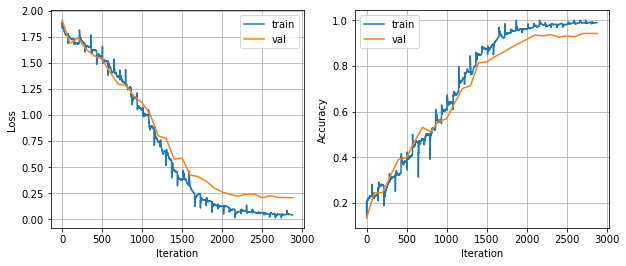

In [40]:
# Training RNN
EPOCHS = 40
ITERS = 3000

LR = 1e-3
WEIGHT_DECAY = 1e-4

MODEL_DIR = './ckpts/rnn/'

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
	os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1  # remember first to set
train(model)

# Evaluate RNN
viz_training_curves()

test(model, './ckpts/rnn/2879.tar')


## Model 4: ANN

### ANN Baseline

Witnessing the great success of state-of-the-art Attention Neural Networks such as Transformers in NLP, we try to apply it in our task. ANNs outperform LSTM on capturing global information of sequences. It benefits from the self-attention mechanism, $V=QK$, where $Q,K,V$ are queries, keys, and values. This design scatters the representation difficulty over the neurons representing the whole sequence. Position information is also encoded , which can help localization and capture the global structure. We replace RNN in the last section (i.e., LSTM) with one kind of Attention Neural Networks, (Vision) Transformer. It consists of multple attention heads and self-attention mechanism. What is slightly different from that in NLP is ViT does not have a decoder. We first implement a single-layer ANN baseline.

![Attention Block](figs/attnblk.png)

![ViT](figs/vit.png)[[1]](https://arxiv.org/abs/2010.11929)


In [41]:
def generate_positional_encoding(seq_length, dim):
    assert dim == 2* (dim//2) # check if dim is divisible by 2
    pe = torch.zeros(seq_length, dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    return pe        
        

class Transformer_encoder(nn.Module):
    
    def __init__(self, hidden_size, nb_heads):
        super(Transformer_encoder, self).__init__()
        assert hidden_size == nb_heads* (hidden_size//nb_heads) # check if hidden_size is divisible by nb_heads
        self.MHA = nn.MultiheadAttention(hidden_size, nb_heads)
        self.LLcat = nn.Linear(2*hidden_size, hidden_size)
        self.LL1 = nn.Linear(hidden_size, hidden_size)
        self.LL2 = nn.Linear(hidden_size, hidden_size)
        self.LN1 = nn.LayerNorm(hidden_size)
        self.LN2 = nn.LayerNorm(hidden_size)
        
    def forward(self, g_seq , pos, return_attn=False):  
        seq_length = g_seq.size(0)
        bs = g_seq.size(1)
        pos = pos.unsqueeze(dim=1).repeat_interleave(bs,dim=1) # size=(seq_length, bs, hidden_dim) 
        h_cat = self.LLcat(torch.cat( (g_seq, pos), dim=2 )) # size=(seq_length, bs, hidden_dim) 
        h_MHA_seq, attn_ws = self.MHA(h_cat, h_cat, h_cat) # size=(seq_length, bs, hidden_dim)
        h = self.LN1( h_cat + h_MHA_seq ) # size=(seq_length, bs, hidden_dim) 2
        # print("h.shape", h.shape)
        h_MLP = self.LL2(torch.relu(self.LL1(h))) # size=(seq_length, bs, hidden_dim) 
        h_seq = self.LN2( h + h_MLP ) # size=(seq_length, bs, hidden_dim) 
        # print("h_seq.shape", h_seq.shape)
        return h_seq if not return_attn else (h_seq, [attn_ws])


class ANN_baseline(nn.Module):
    """ Analogous to ViT."""
    def __init__(self, *, image_size, patch_size, num_classes, hidden_size, heads, channels = 3):
        super(ANN_baseline, self).__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, hidden_size),
        )

        self.hidden_size = hidden_size
        self.transformer = Transformer_encoder(hidden_size, heads)

        self.to_latent = nn.AdaptiveAvgPool1d(1)  # temporal average pooling
        self.mlp_head = nn.Linear(    hidden_size , num_classes   )

    def forward(self, img, return_attn=False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        x = x.transpose(1, 0) 
        pos = generate_positional_encoding(n, self.hidden_size).cuda()

        if not return_attn:
            x = self.transformer(x, pos)
        else:
            x, attn_ws = self.transformer(x, pos, return_attn=True)

        x = x.permute(1, 2, 0)
        x = self.to_latent(x).view(b, -1)

        return self.mlp_head(x) if not return_attn else (self.mlp_head(x), attn_ws)


# ANN configurations
HIDDEN_SIZE=128
NUM_HEADS = 4

model = ANN_baseline(
    image_size=IMG_SIZE,
    patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
    num_classes=NUM_CLASSES,
    hidden_size=HIDDEN_SIZE,
    heads=NUM_HEADS,  
).cuda()

print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 157958
ANN_baseline(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=192, out_features=128, bias=True)
  )
  (transformer): Transformer_encoder(
    (MHA): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (LLcat): Linear(in_features=256, out_features=128, bias=True)
    (LL1): Linear(in_features=128, out_features=128, bias=True)
    (LL2): Linear(in_features=128, out_features=128, bias=True)
    (LN1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (LN2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (to_latent): AdaptiveAvgPool1d(output_size=1)
  (mlp_head): Linear(in_features=128, out_features=6, bias=True)
)


Epoch-Iter [0-0]	Train loss: 2.164950 Train acc: 0.09375; Val loss: 2.041757 Val acc: 0.16520 LR: 0.000033 | Time: 0.2102
Epoch-Iter [1-99]	Train loss: 1.739876 Train acc: 0.15625; Val loss: 1.723390 Val acc: 0.21968 LR: 0.000999 | Time: 0.0428
Epoch-Iter [2-199]	Train loss: 1.562827 Train acc: 0.39062; Val loss: 1.611571 Val acc: 0.32865 LR: 0.000992 | Time: 0.0432
Epoch-Iter [4-299]	Train loss: 1.604273 Train acc: 0.32812; Val loss: 1.528086 Val acc: 0.38664 LR: 0.000980 | Time: 0.0430
Epoch-Iter [5-399]	Train loss: 1.271030 Train acc: 0.60938; Val loss: 1.383936 Val acc: 0.45694 LR: 0.000962 | Time: 0.0426
Epoch-Iter [6-499]	Train loss: 1.454256 Train acc: 0.40625; Val loss: 1.370890 Val acc: 0.45518 LR: 0.000939 | Time: 0.0424
Epoch-Iter [8-599]	Train loss: 1.391395 Train acc: 0.54688; Val loss: 1.324902 Val acc: 0.52373 LR: 0.000912 | Time: 0.0422
Epoch-Iter [9-699]	Train loss: 1.179610 Train acc: 0.51562; Val loss: 1.267738 Val acc: 0.51142 LR: 0.000880 | Time: 0.0420
Epoch-Iter 

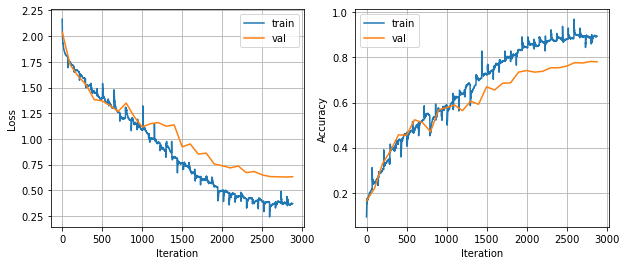

In [42]:
# Training
EPOCHS = 40
ITERS = 3000

LR = 1e-3
WEIGHT_DECAY = 0.

MODEL_DIR = './ckpts/ann_baseline/'

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# lr_scheduler = NoamOpt(1, LR * WARMUPS ** 0.5, WARMUPS, optimizer)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
	os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1  # remember first to set
train(model)

viz_training_curves()

test(model, './ckpts/ann_baseline/2879.tar')


### Our Improved ANN

We continue to stack more attention blocks to increase the representation power. Instead of using a temporal global pooling, we follow ViT to add a class-specific token for the prediction. The class token can fuse more sufficiently with hidden states at every level. To prevent overfitting, we additionally use the dropout techique in ANNs which randomly drops some neurons out during the training to prevent co-adaptation.

In [43]:
# Transformer, analogous to nn.Transformer.
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x, return_attn=False):
        qkv = self.to_qkv(x).chunk(3, dim = -1)  # type: tuple
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out) if not return_attn else (self.to_out(out), attn)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x, return_attn=False):
        attn_ws = []
        for attn, ff in self.layers:
            if not return_attn:
                attn_out = attn(x)
            else:
                attn_out, attn_w = attn(x, return_attn=True)

            x = attn_out + x
            x = ff(x) + x

            if return_attn:
                attn_ws.append(attn_w)

        return x if not return_attn else (x, attn_ws)


class ANN(nn.Module):
    """ Analogous to ViT."""
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super(ANN, self).__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, return_attn=False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        # print("cls_tokens.shape after repeat", cls_tokens.shape)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        if not return_attn:
            x = self.transformer(x)
            # print("x.shape after transformer", x.shape)
        else:
            x, attn_ws = self.transformer(x, return_attn=True)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x) if not return_attn else (self.mlp_head(x), attn_ws)


# ANN configurations
DIM = 64
# DEPTH = 4
DEPTH = 6 
NUM_HEADS = 6
MLP_DIM = 128
# DIM_HEAD = 128
DIM_HEAD = 150
DROPOUT = 0.1

model = ANN(
    image_size=IMG_SIZE,
    patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
    num_classes=NUM_CLASSES,
    dim=DIM,
    depth=DEPTH,
    heads=NUM_HEADS,  
    mlp_dim=MLP_DIM,
    dim_head=DIM_HEAD,
    dropout=DROPOUT,
    # emb_dropout=0.1
).cuda()

print("#Total params", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


#Total params 1499078
ANN(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=192, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=2700, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=900, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): GELU()
   

Epoch-Iter [0-0]	Train loss: 1.802329 Train acc: 0.23438; Val loss: 1.893632 Val acc: 0.18102 LR: 0.000033 | Time: 0.2124
Epoch-Iter [1-99]	Train loss: 1.708239 Train acc: 0.31250; Val loss: 1.709774 Val acc: 0.29174 LR: 0.000999 | Time: 0.0551
Epoch-Iter [2-199]	Train loss: 1.631072 Train acc: 0.26562; Val loss: 1.569892 Val acc: 0.33568 LR: 0.000992 | Time: 0.0542
Epoch-Iter [4-299]	Train loss: 1.661643 Train acc: 0.32812; Val loss: 1.569600 Val acc: 0.36380 LR: 0.000980 | Time: 0.0542
Epoch-Iter [5-399]	Train loss: 1.402845 Train acc: 0.46875; Val loss: 1.399345 Val acc: 0.45167 LR: 0.000962 | Time: 0.0536
Epoch-Iter [6-499]	Train loss: 1.110507 Train acc: 0.59375; Val loss: 1.312143 Val acc: 0.49033 LR: 0.000939 | Time: 0.0532
Epoch-Iter [8-599]	Train loss: 1.305564 Train acc: 0.50000; Val loss: 1.317440 Val acc: 0.47627 LR: 0.000912 | Time: 0.0529
Epoch-Iter [9-699]	Train loss: 1.044464 Train acc: 0.65625; Val loss: 1.141010 Val acc: 0.58699 LR: 0.000880 | Time: 0.0530
Epoch-Iter 

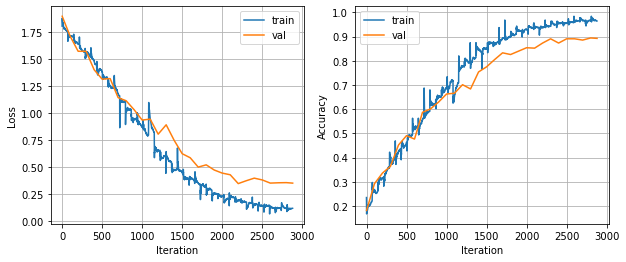

In [44]:
# Training
EPOCHS = 40
ITERS = 3000

LR = 1e-3
WEIGHT_DECAY = 1e-3

MODEL_DIR = './ckpts/ann/'

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# lr_scheduler = NoamOpt(1, LR * WARMUPS ** 0.5, WARMUPS, optimizer)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, WARMUPS, ITERS)

if not os.path.isdir(MODEL_DIR):
	os.mkdir(MODEL_DIR)

start_epoch, step = 0, -1  # remember first to set
train(model)

viz_training_curves()

test(model, './ckpts/ann/2879.tar')


# Step 6: Numerical Results and Visualizations

**Tasks:**

First, we will visualize feature representations learned  by  our  models to  show  how  effective these models are. For example, we can check whether the model pays attention to accurate regions with CAM (Class Activation Mapping).  

Secondly, we verify  the  effects  of  each  model  and  training  design. Apart  from  normal  test  generalization,  out-of-domain  (-distribution) generalization is also studied, e.g., how  robust  the  model  is to some perturbations and attacks.  We can cast some insights  on  future  steps  based  on  the  analysis  of  potential disadvantages of current models.

**Conclusion:**
CNNs and ANNs can learn discriminative patterns and representations for data. CNNs consistently outperform other models on the OOD robust test. It shows in the scenario of not large data, CNNs are still the ideal model choice for image classification making our application successful.


In [45]:
# Load checkpoints
MODEL_DIR = './ckpts/mlp/2879.tar'
mlp = MLP(INPUT_DIM, HIDDEN_SIZE, NUM_CLASSES).cuda()
mlp.load_state_dict(torch.load(MODEL_DIR, map_location=DEVICE)['model'])
mlp.eval()

MODEL_DIR = './ckpts/cnn/2879.tar'
cnn = CNN(num_blocks=[2, 2, 2]).cuda()
cnn.load_state_dict(torch.load(MODEL_DIR, map_location=DEVICE)['model'])
cnn.eval()

MODEL_DIR = './ckpts/rnn/2879.tar'
rnn = RNN(
    image_size=IMG_SIZE,
    patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
    num_classes=NUM_CLASSES,
    dim=DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
).cuda()
rnn.load_state_dict(torch.load(MODEL_DIR, map_location=DEVICE)['model'])
rnn.eval()

MODEL_DIR = './ckpts/ann/2879.tar'
ann = ANN(image_size=IMG_SIZE,
          patch_size=IMG_SIZE // int(SEQ_LEN ** 0.5),
          num_classes=NUM_CLASSES,
          dim=DIM,
          depth=DEPTH,
          heads=NUM_HEADS,
          mlp_dim=MLP_DIM,
          dim_head=DIM_HEAD,
          dropout=DROPOUT).cuda()
ann.load_state_dict(torch.load(MODEL_DIR, map_location=DEVICE)['model'])
ann.eval();


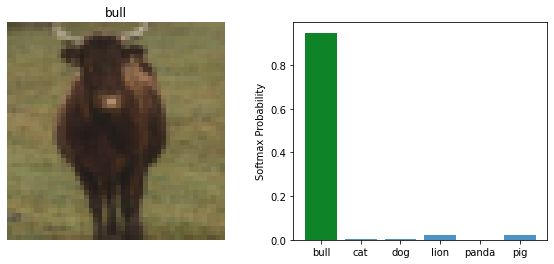

In [46]:
# Predictions and probability
img, label = test_dataset[0] # only one image
img = img.unsqueeze(0)
with torch.no_grad():
	output = cnn(img.cuda())
prob = F.softmax(output, dim=1).cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.title(test_dataset.classes[label])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(np.arange(NUM_CLASSES), prob[0].numpy(), alpha=0.8)
plt.bar(prob.max(1)[1], prob.max(1)[0], color='g', alpha=0.8)
_ = plt.xticks(np.arange(NUM_CLASSES), test_dataset.classes)
_ = plt.ylabel('Softmax Probability')


## Class-Balanced Good Performance

Due to our careful inspection and balanced data split, the model achieves similar good performance on each class.

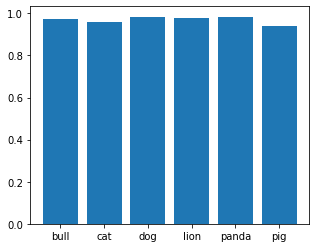

In [47]:
def accuracy_per_class(model):
    accs = [AvgMeter() for _ in range(NUM_CLASSES)]

    model = model.eval()

    for imgs, labels in test_dataloader:
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        with torch.no_grad():
            outputs = model(imgs)

        coins = outputs.max(1)[1] == labels
        
        for class_ in range(NUM_CLASSES):
            accs[class_].update(coins[labels == class_].float().mean().item(),
                                (labels == class_).sum().item())
    
    plt.figure(figsize=(5, 4))
    plt.bar(np.arange(NUM_CLASSES), [acc.mean for acc in accs])
    plt.xticks(np.arange(NUM_CLASSES), test_dataset.classes)


accuracy_per_class(cnn)


## Attention Visualizations

### CAM for CNNs

We use [Grad-CAM (Class Activation Maps)](https://arxiv.org/abs/1610.02391) to get a sense of what the model (CNN) pays attention to. Using this technique, we do not need re-training like original [CAM (Zhou et al., 2016)](https://arxiv.org/abs/1512.04150). Basically, it highlights the parts which have most impacts on the objective. We find CNNs really seem to focus on some discriminative parts of objects and reasonable scenes, like the mouth of lions and grass.

In [48]:
# !pip install grad-cam


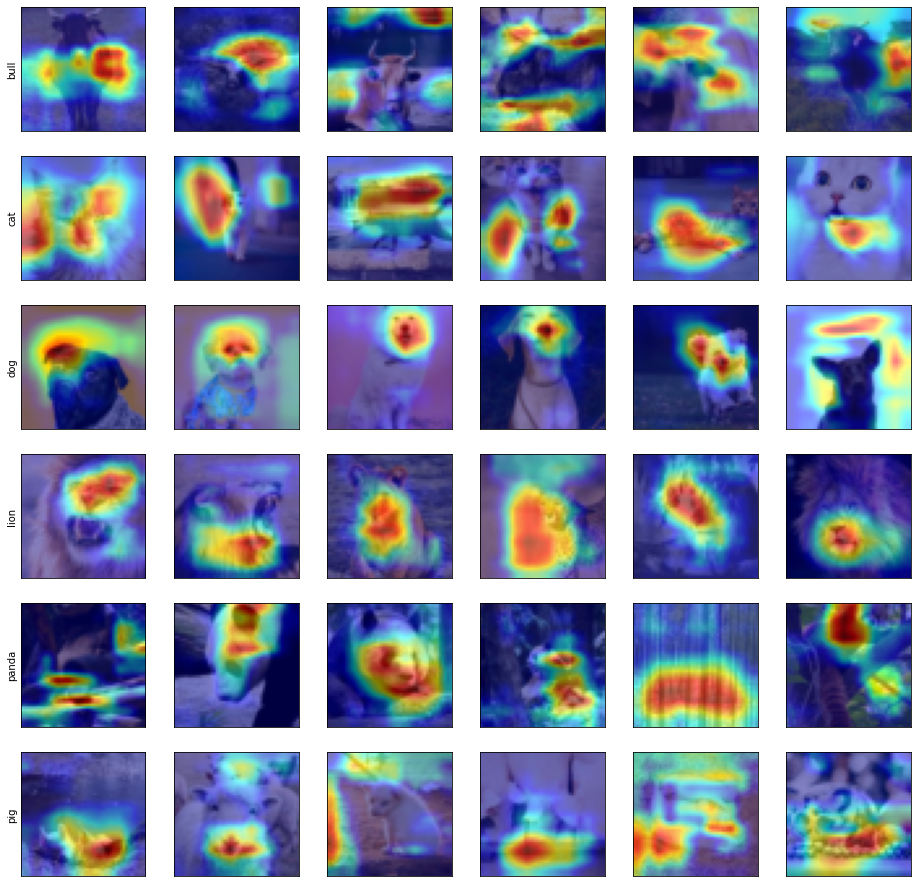

In [49]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


target_layers = [cnn.layer3[-1]]
cam = GradCAM(model=cnn, target_layers=target_layers)

viz_per_class = NUM_CLASSES
plt.figure(figsize=(16, 16))

cnt = 0

for class_ in range(NUM_CLASSES):
    for img, label in test_dataset:
        if label == class_:
            target_category = label
            grayscale_cam = cam(input_tensor=img.unsqueeze(0).cuda(), target_category=label)  # device: GPU
            grayscale_cam = grayscale_cam[0, :]
            rgb_img = img.numpy().transpose(1, 2, 0)  # type: np.ndarray
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            cnt += 1
            plt.subplot(NUM_CLASSES, viz_per_class, cnt)
            plt.imshow(visualization)
            if cnt % viz_per_class == 1:
                plt.ylabel(test_dataset.classes[class_])
            plt.xticks([])
            plt.yticks([])

            if cnt % viz_per_class == 0:
                break


### Attention Weights of ANNs

Besides, we also use the visualization approach in [ViT](https://github.com/jeonsworld/ViT-pytorch) to visualize the attention of ANNs. Basically, what we need to do is just to multiply all the attention weights in different layers of blocks. Perceptually, it shows ANNs also have reasonable cues for predictions instead of spurious ones. Note that, it is not conventional to inspect patterns captured by MLPs and RNNs, so we do not involve them here.


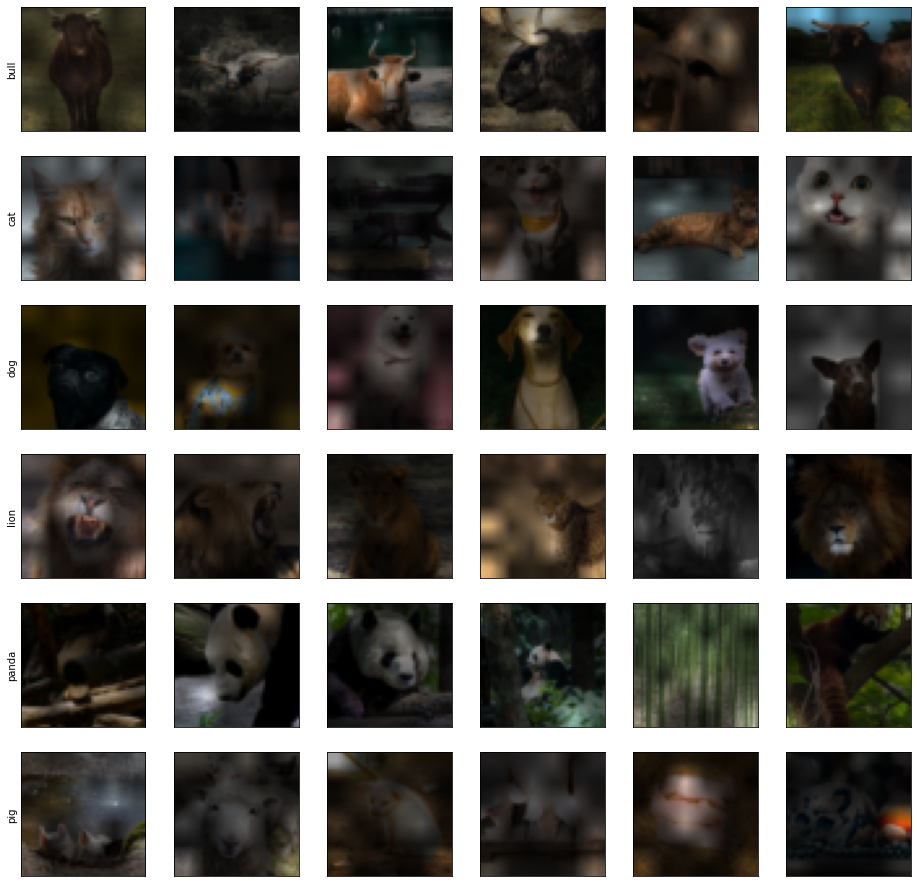

In [50]:
import cv2


def viz_attn_ann(x):
    logits, att_mat = ann.cpu()(x.unsqueeze(0), return_attn=True)
    
    att_mat = torch.stack(att_mat).squeeze(1)
    
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    im = transforms.ToPILImage()(x)
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    return result


viz_per_class = NUM_CLASSES
plt.figure(figsize=(16, 16))

cnt = 0

for class_ in range(NUM_CLASSES):
    for img, label in test_dataset:
        if label == class_:
            visualization = viz_attn_ann(img)
            
            cnt += 1
            plt.subplot(NUM_CLASSES, viz_per_class, cnt)
            plt.imshow(visualization)
            if cnt % viz_per_class == 1:
                plt.ylabel(test_dataset.classes[class_])
            plt.xticks([])
            plt.yticks([])

            if cnt % viz_per_class == 0:
                break
  

## Feature Representation Clustering

We visualize the feature representations before the last linear-layer classifier for each model. We can see deep CNNs and ANNs are good at extracting high-level discriminative feature representations for images of each class, compared with the mixture visualization in the data exploration section. Not so good representations of MLPs and RNNs also announce its inferiority. Good representations not only help classfication, but also are good for downstream tasks.


In [51]:
# Save intermediate feature representations
class SaveFeatures():
    """ Forward hook for obtaining feature representations."""
    def __init__(self, module: nn.Module) -> None:
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module: nn.Module, input: Tensor, output: Tensor) -> None:
        self.features = output.requires_grad_().cuda()

    def close(self) -> None:
        self.hook.remove()


def get_feat_reprs(model: nn.Module, layer: nn.Module, dataloader: data.DataLoader) -> Tensor:
    feats, labels = [], []

    # Register the forward hook
    feat_regis = SaveFeatures(layer)

    model.eval()

    for img, label in dataloader:
        img = img.cuda(non_blocking=True)
        with torch.no_grad():
            _ = model(img)
        feats_batch = feat_regis.features.detach()
        if isinstance(model, CNN):
            # Further pass avg pooling
            feats_batch = F.avg_pool2d(feats_batch, feats_batch.size(3))
        feats.append(feats_batch.flatten(start_dim=1))  # GPU
        labels.append(label)
    feats = torch.cat(feats).cpu()
    labels = torch.cat(labels)

    return feats, labels


In [52]:
''' 2d visulaization 
    output: decomposed features (n*2), labels: (n*1) '''
def plot_decompose(output, labels, color_dict, title, xlabel, ylabel):
  plt.figure()
  for _i, label in enumerate(labels):
    plt.scatter(output[_i, 0], output[_i, 1], c=color_dict[label])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

color_dict = {"lion": "red", "cat": "green", "dog": "blue", "pig": "yellow", "panda": "pink", "bull": "black"}


In [53]:
# t-SNE visualization
def feat_repr_tsne(model: nn.Module, layer: nn.Module, dataloader: data.DataLoader,
                   model_name: str) -> None:
    tsne = manifold.TSNE(n_components=2, init="random", random_state=0, perplexity=10)

    feats, labels = get_feat_reprs(model.cuda(), layer, dataloader)
    labels = [test_dataset.classes[label] for label in labels]

    tsne_output = tsne.fit_transform(feats)

    title, xlabel, ylabel = f"Tsne Decomposition for {model_name} Features", "Tsne_x", "Tsne_y"
    plot_decompose(tsne_output, labels, color_dict, title, xlabel, ylabel)


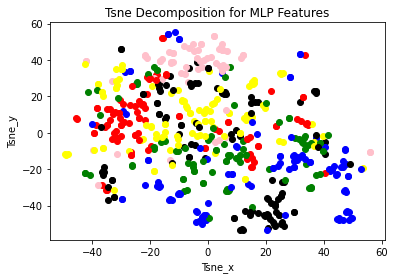

In [54]:
feat_repr_tsne(mlp, mlp.relu2, test_dataloader, 'MLP')


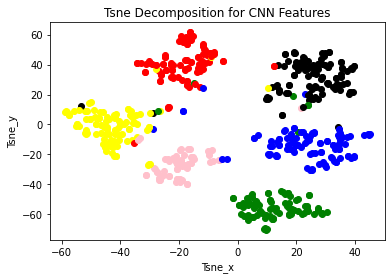

In [55]:
feat_repr_tsne(cnn, cnn.layer3, test_dataloader, 'CNN')


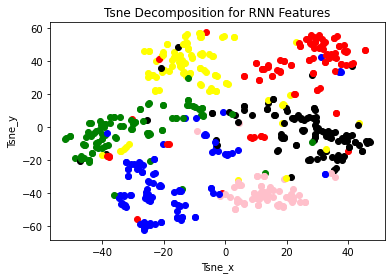

In [56]:
feat_repr_tsne(rnn, rnn.mlp_head[0], test_dataloader, 'RNN')


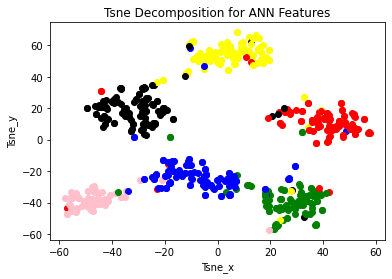

In [57]:
feat_repr_tsne(ann, ann.mlp_head[0], test_dataloader, 'ANN')


We also investigate the frequency of each neuron being activated on the input images. Basically, we compute the entropy of activations normalized over data. The less the value is, the less proportion of data the neuron is activated on, meaning the feature pattern learn by the neuron is more discriminative. It reveals the sparsity of representations to some extent as well. We find the proportion of activated neurons of larger ANNs is less.

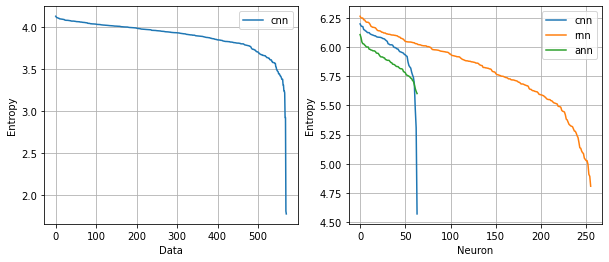

In [58]:
# Activation and sparsity
acts = {}
acts['cnn'], _ = get_feat_reprs(cnn, cnn.layer3, test_dataloader)
acts['rnn'], _ = get_feat_reprs(rnn, rnn.mlp_head[0], test_dataloader)
acts['ann'], _ = get_feat_reprs(ann, ann.mlp_head[0], test_dataloader)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# Since RNN and ANN use LayerNorm, we do not analyze them along the data axis
model_t, act = 'cnn', acts['cnn']
entropy = (-F.softmax(act, dim=1) * F.log_softmax(act, dim=1)).sum(1)
order = (-entropy).argsort()
plt.plot(entropy[order], label=model_t)
plt.xlabel('Data')
plt.ylabel('Entropy')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
for model_t, act in acts.items():
    entropy = (-F.softmax(act, dim=0) * F.log_softmax(act, dim=0)).sum(0)
    order = (-entropy).argsort()
    plt.plot(entropy[order], label=model_t)
plt.xlabel('Neuron')
plt.ylabel('Entropy')
plt.grid()
plt.legend()


## Perturbation Robust Test

Our data are limited, so the model has the risk of overfitting and not generalizing well to the application. We study the robustness of models towards perturbations such as the change of frequency resolutions and occlusions. The former is to verify if training data augmentations are selected appropriately to handle some resolution scales. The later is to test if models reply on non-semantic parts to predict, like spurious background information. Background constitutes a large part of the image and can be removed in the test. We can see our CNNs consistently outperform other models on both tests, meaning it is less overfitting and captures more informative object features.

In [59]:
# Perturbation robustness test: Mainly small resize, occlusion
def perturb_robust_test(transform: Callable):
    freq_res_dataset = MyDataset(split='test', transform=transform)
    freq_res_dataloader = data.DataLoader(freq_res_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    
    viz_batch_of_dataset(freq_res_dataset)
    for model in ['mlp', 'cnn', 'rnn', 'ann']:
        _, acc = validate(eval(model), freq_res_dataloader)
        print(f"[{model}] Robust Acc: {acc:.5f}")


> Loading images for test
[mlp] Robust Acc: 0.77408
[cnn] Robust Acc: 0.93520
[rnn] Robust Acc: 0.91769
[ann] Robust Acc: 0.81786


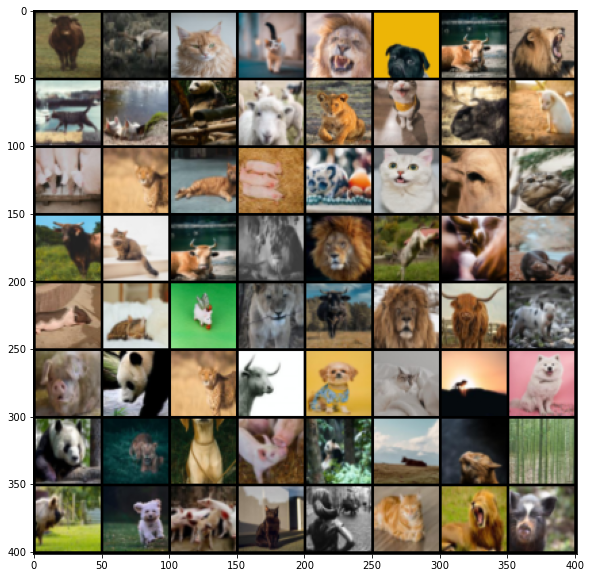

In [60]:
# Frequency resolution perturbation test
freq_res_transform = transforms.Compose([
	transforms.Resize(IMG_SIZE),
	transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.2)),
	transforms.ToTensor()
])
perturb_robust_test(freq_res_transform)


> Loading images for test
[mlp] Robust Acc: 0.62172
[cnn] Robust Acc: 0.82312
[rnn] Robust Acc: 0.77233
[ann] Robust Acc: 0.67776


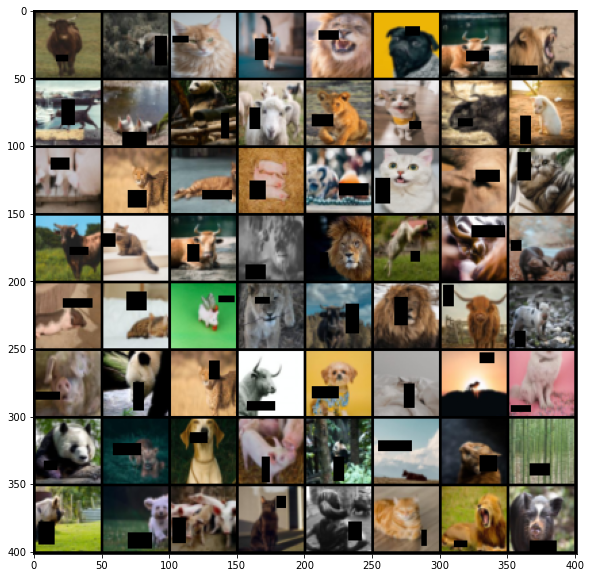

In [61]:
# Occlusion perturbation test
occlusion_transform = transforms.Compose([
	transforms.Resize(IMG_SIZE),
	transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.2)),
	transforms.ToTensor(),
	transforms.RandomErasing(p=1, scale=(0.02, 0.1))
])
perturb_robust_test(occlusion_transform)


# Conclusion and Discussion of the project:

**Conclusions:**

1. We use crawler to get the images from the website "unsplash".

2. We discover the distribution of length and width of the images. Moreover, it is difficult to classify images using Gobar and SIFT features. The t-SNE with PCA decompositions still cannot cluster the images smoothly.

3. When comparing baselines, the order of accuracy is from high to low: ANN -baseline > RNN-baseline > CNN-baseline > MLP-baseline.

4. when comparing improvement, the order of accuracy is from high to low: ANN -improvement > RNN-improvement > CNN-improvement > MLP-improvement.

**Additional Applications:**

1. (Zoo monitoring) Our project can also help zoos to manage dangerous wild animals. For example, it is dangerous if the zoo director has to personally check if the lions are still in the park. With this project, animal detection, we can find lions based on pictures taken by monitoring devices.

2. (Species Recognition) This project comes from animal recognition. It also scales well for has good scalability in other image recognition. For example, this code is reproductive for plant and furniture recognition if enough images are available. However, it should be noted that other recognition tasks may need to consider their specific features in model development.

**Future development:**
1. (Video) Current animal recognition based on static images cannot fully meet the requirements of recognition based on videos. In the era of the advent of short videos, we hope that our project can be extended based on videos.

2. (Fine-grained) More accurate animal recognition, especially in recognising similar animals, is also our goal for future improvement. We hope that our model can detect subtle differences in similar animals by designing different struts. As an example, Shiba Inu and Akita both belong to dogs. Although they look very similar, they are actually different species. So we still need to address the question of how to achieve fine-grained recognition between different types in one species.

3. (Scene information) Describing the scene around the animals is also a goal that we would like to extend. For example, the result of our project can only tell us that there is a panda, but not that the panda eats bamboo. Richer content besides the animal itself is also very interesting and can give us more information.


# Schedule:













Group 30 contains Rongyu Chen, Zitai Chen, Xiaohui Liu. The detailed schedule is shown as the following table.



|  Step   | Content| Team Member  |
|  ----  | ----  | ----|
| Step 2  | Data Collection | Zitai Chen|
| Step 3  | Data exploration | Xiaohui Liu|
| Step 4  | Pre-processing | Rongyu Chen|
| Step 5  | MLP base line & improvement |Rongyu Chen & Zitai Chen & Xiaohui Liu|
| Step 5  | CNN base line & improvement |Rongyu Chen & Zitai Chen & Xiaohui Liu|
| Step 5  | RNN base line & improvement |Rongyu Chen & Zitai Chen & Xiaohui Liu|
| Step 5  | ANN base line & improvement |Rongyu Chen & Zitai Chen & Xiaohui Liu|
| Step 6  | Numerical results |Rongyu Chen & Zitai Chen & Xiaohui Liu |

------

**The End**

Really enjoy this course CS5242!

Really appreciate for Prof and TAs' effort. Thanks a lot!

